In [46]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

# Making results folder -- change to what this should actually be 
path = '/Volumes/Seagate Desktop Drive/NARSAD/'
os.chdir(path)


### making ROI mask (lateral ROIs combined into 1 bilateral ROI)

BIDS Layout: ...sktop Drive/NARSAD/derivatives | Subjects: 102 | Sessions: 102 | Runs: 10


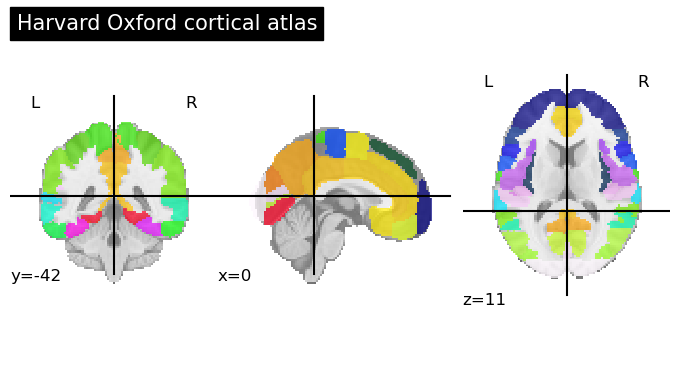

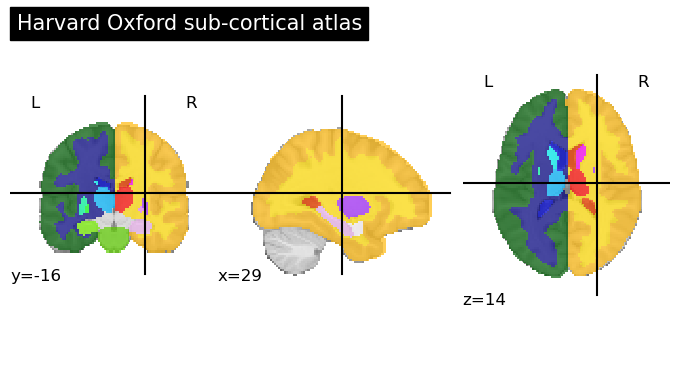

In [47]:
import numpy as np
from nilearn import datasets
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn import plotting, masking
from nilearn.masking import _unmask_3d
from nilearn.maskers import nifti_spheres_masker
import nibabel as nib
from nibabel import Nifti1Image
from nilearn.image import resample_to_img 

dataset_ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm", symmetric_split=False) #changing from bilateral to combined left/right
atlas_ho_cort_filename = dataset_ho_cort.filename
plotting.plot_roi(atlas_ho_cort_filename, title="Harvard Oxford cortical atlas")

dataset_ho_sub = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm", symmetric_split=False)
atlas_ho_sub_filename = dataset_ho_sub.filename
plotting.plot_roi(atlas_ho_sub_filename, title="Harvard Oxford sub-cortical atlas")

layout = bids.BIDSLayout('/Volumes/Seagate Desktop Drive/NARSAD/derivatives', validate=False,
                  config=['bids','derivatives'])
print(layout)

In [48]:
#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

In [53]:
dataset_ho_cort

{'filename': '/Users/angelafang/nilearn_data/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
 'maps': <nibabel.nifti1.Nifti1Image at 0x144775af0>,
 'labels': ['Background',
  'Frontal Pole',
  'Insular Cortex',
  'Superior Frontal Gyrus',
  'Middle Frontal Gyrus',
  'Inferior Frontal Gyrus, pars triangularis',
  'Inferior Frontal Gyrus, pars opercularis',
  'Precentral Gyrus',
  'Temporal Pole',
  'Superior Temporal Gyrus, anterior division',
  'Superior Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, anterior division',
  'Middle Temporal Gyrus, posterior division',
  'Middle Temporal Gyrus, temporooccipital part',
  'Inferior Temporal Gyrus, anterior division',
  'Inferior Temporal Gyrus, posterior division',
  'Inferior Temporal Gyrus, temporooccipital part',
  'Postcentral Gyrus',
  'Superior Parietal Lobule',
  'Supramarginal Gyrus, anterior division',
  'Supramarginal Gyrus, posterior division',
  'Angular Gyrus',
  'Lateral Occipital C

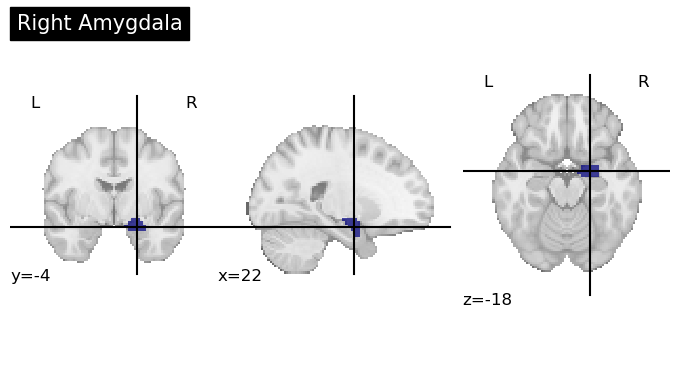

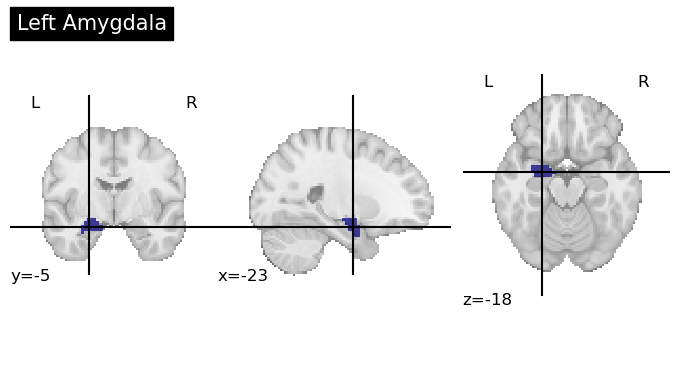

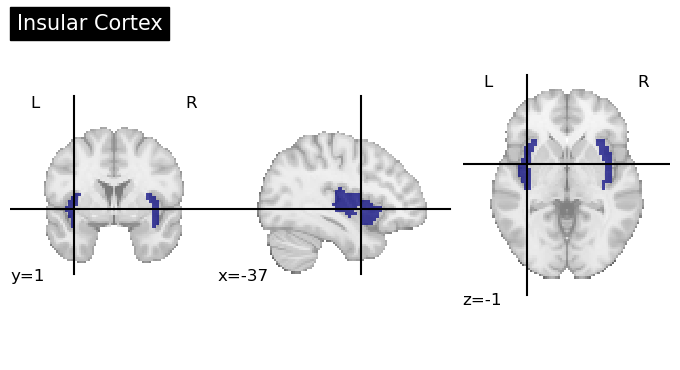

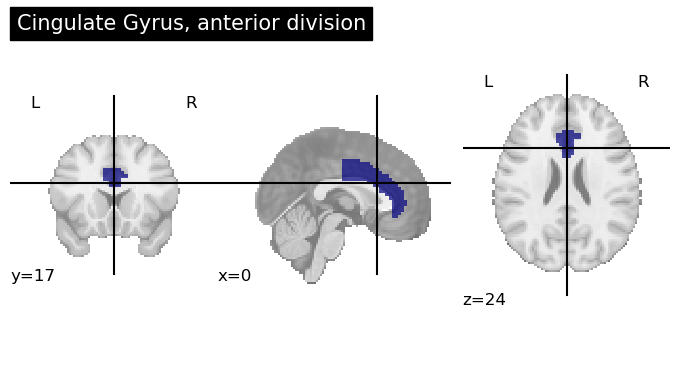

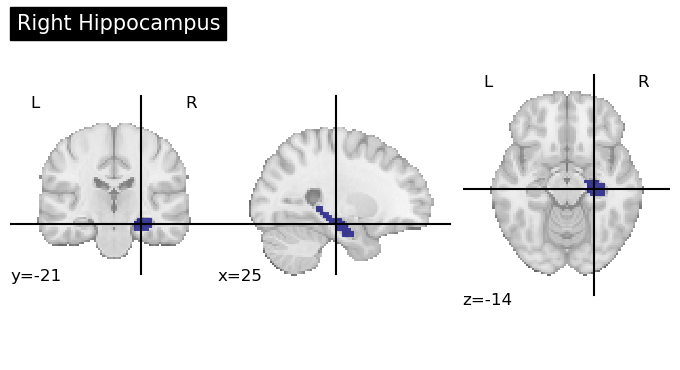

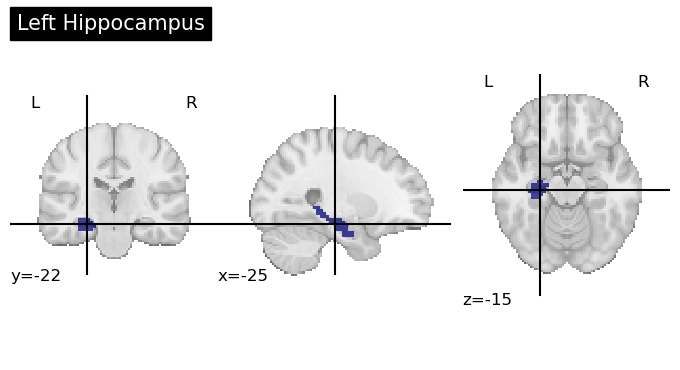

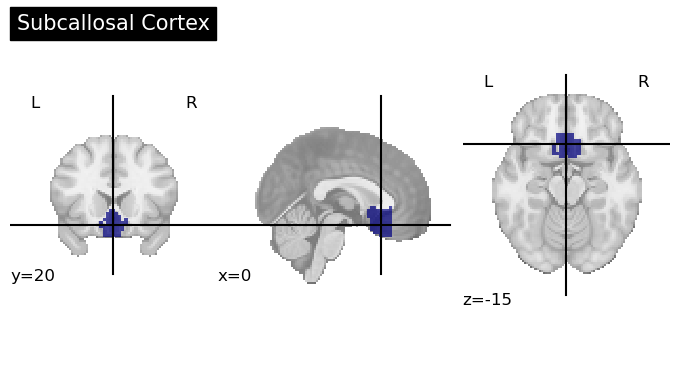

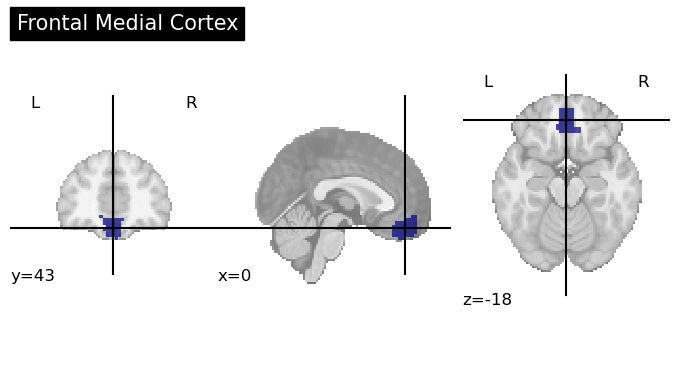

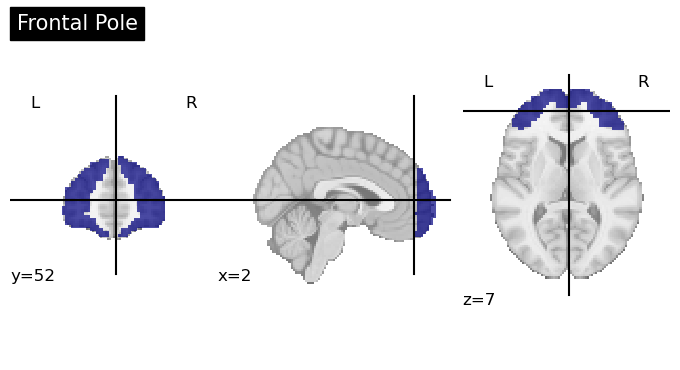

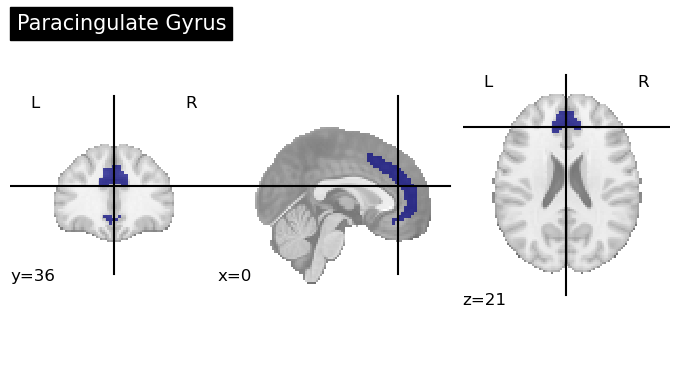

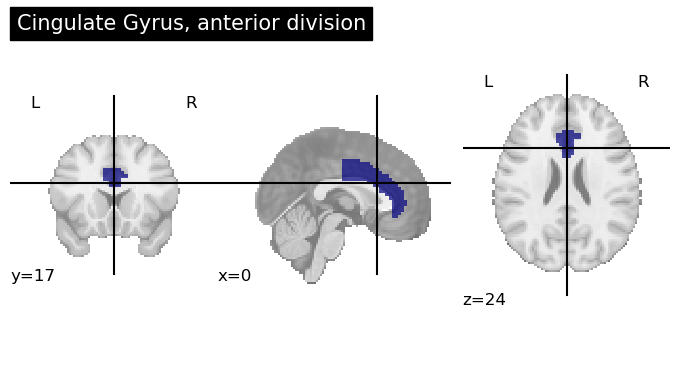

In [54]:
def create_and_plot_roi(label_of_interest, dataset, atlas_resampled):
    index_of_interest = dataset['labels'].index(label_of_interest)
    nii_data = atlas_resampled.get_fdata()
    roi_data = np.where(nii_data == index_of_interest, nii_data, 0)
    binarized_data = (roi_data > 0).astype(bool)
    
    roi_atlas = Nifti1Image(binarized_data, atlas_resampled.affine, header=atlas_resampled.header)
    plotting.plot_roi(roi_atlas, title=label_of_interest)
    
    return roi_atlas

#resample atlas map to data shape
atlas_sub_resampled = resample_to_img(source_img=dataset_ho_sub['maps'], target_img=space_defining_image, interpolation='nearest')
atlas_cort_resampled = resample_to_img(source_img=dataset_ho_cort['maps'], target_img=space_defining_image, interpolation='nearest')

right_amygdala_atlas = create_and_plot_roi('Right Amygdala', dataset_ho_sub, atlas_sub_resampled)
left_amygdala_atlas = create_and_plot_roi('Left Amygdala', dataset_ho_sub, atlas_sub_resampled)
insula_atlas = create_and_plot_roi('Insular Cortex', dataset_ho_cort, atlas_cort_resampled)
acc_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)
right_hippocampus_atlas = create_and_plot_roi('Right Hippocampus', dataset_ho_sub, atlas_sub_resampled)
left_hippocampus_atlas = create_and_plot_roi('Left Hippocampus', dataset_ho_sub, atlas_sub_resampled)
vmpfc1_atlas = create_and_plot_roi('Subcallosal Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc2_atlas = create_and_plot_roi('Frontal Medial Cortex', dataset_ho_cort, atlas_cort_resampled)
vmpfc3_atlas = create_and_plot_roi('Frontal Pole', dataset_ho_cort, atlas_cort_resampled)
vmpfc4_atlas = create_and_plot_roi('Paracingulate Gyrus', dataset_ho_cort, atlas_cort_resampled)
vmpfc5_atlas = create_and_plot_roi('Cingulate Gyrus, anterior division', dataset_ho_cort, atlas_cort_resampled)


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/image/image.py:1106: UserWarning: Data array

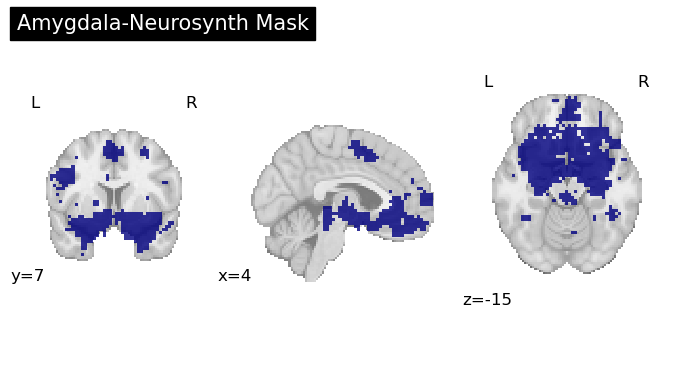

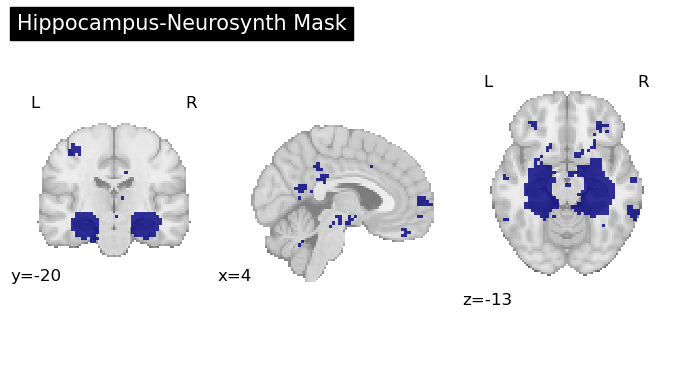

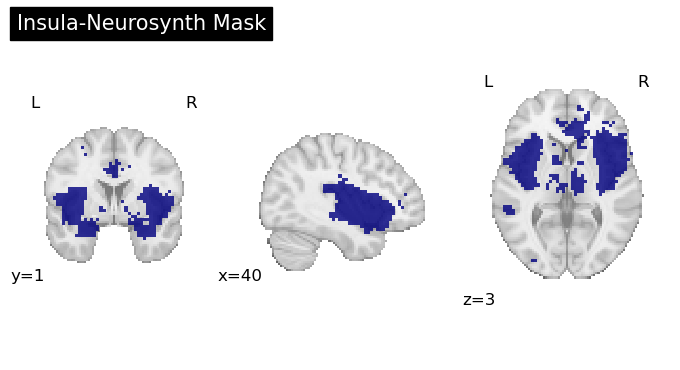

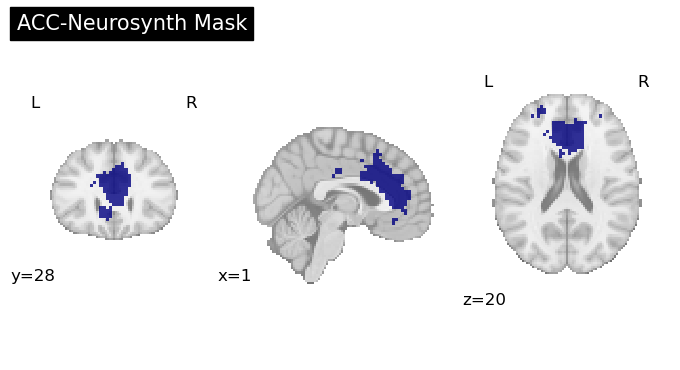

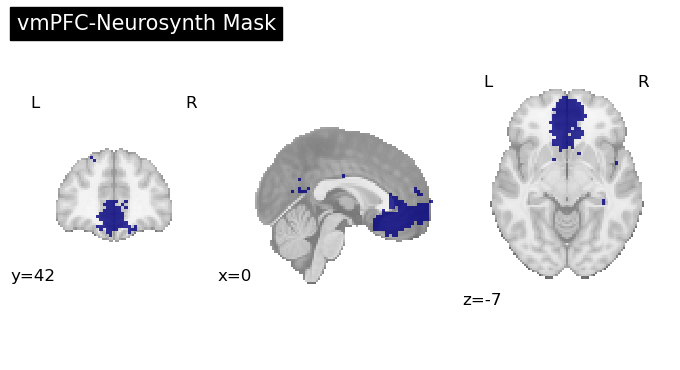

In [55]:
# load in/plot neurosynth masks: 
# #import Neurosynth masks:
from nilearn.image import binarize_img

amygdala_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/amygdala.nii.gz')
amygdala_func = binarize_img(resample_to_img(source_img=amygdala_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(amygdala_func, draw_cross=False, alpha=0.8, title='Amygdala-Neurosynth Mask')

hippocampus_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/hippocampus.nii.gz')
hippocampus_func = binarize_img(resample_to_img(source_img=hippocampus_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(hippocampus_func, draw_cross=False, alpha=0.8, title='Hippocampus-Neurosynth Mask')

insula_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/insula.nii.gz')
insula_func = binarize_img(resample_to_img(source_img=insula_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(insula_func, draw_cross=False, alpha=0.8, title='Insula-Neurosynth Mask')

acc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/acc.nii.gz')
acc_func = binarize_img(resample_to_img(source_img=acc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(acc_func, draw_cross=False, alpha=0.8, title='ACC-Neurosynth Mask')

vmpfc_func = load_img('/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/neurosynth-raw/vmpfc.nii.gz')
vmpfc_func = binarize_img(resample_to_img(source_img=vmpfc_func, target_img=space_defining_image, interpolation='nearest'))
plotting.plot_roi(vmpfc_func, draw_cross=False, alpha=0.8, title='vmPFC-Neurosynth Mask')


/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_18934/976521645.py:11: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  amygdala = new_img_like(space_defining_image, amygdala)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_18934/976521645.py:20: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  hippocampus = new_img_like(space_defining_image, hippocampus)
/var/folders/s0/646xnw3j2bb_xf44ysxm7k680000gn/T/ipykernel_18934/976521645.py:26: UserWarning: Data array used to create a new image con

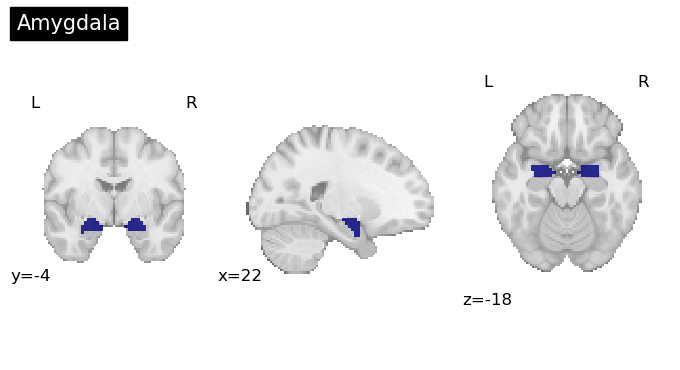

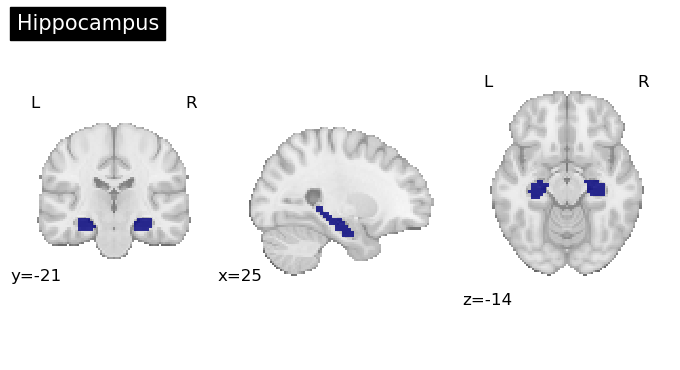

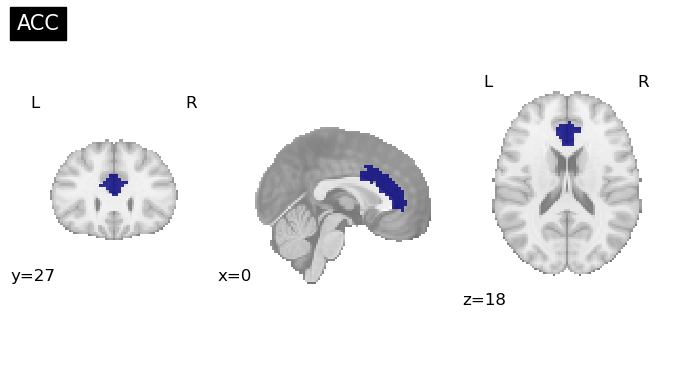

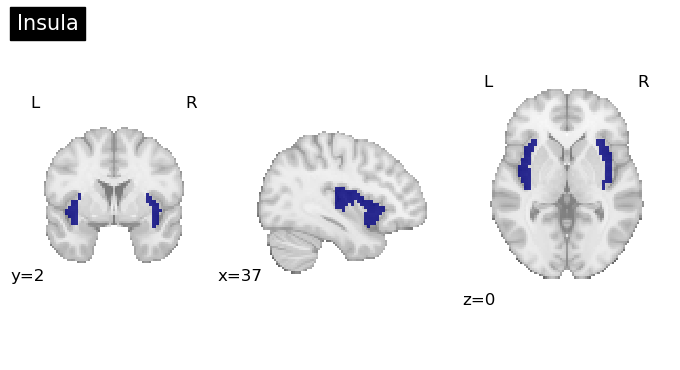

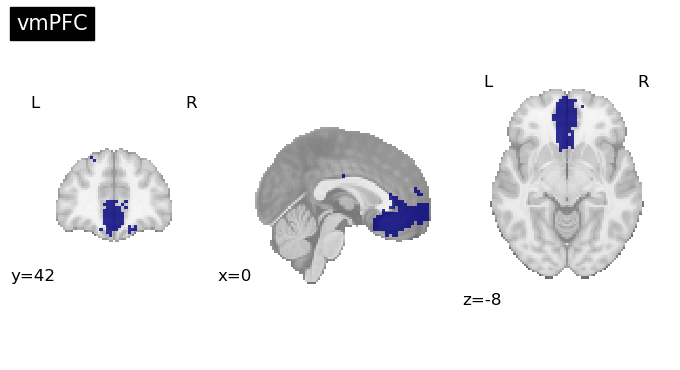

In [56]:
path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

# anatomically-constraining functional ROIs + lateralizing 
from nilearn.image import new_img_like
right_amygdala = np.logical_and(amygdala_func.get_fdata(),right_amygdala_atlas.get_fdata())
right_amygdala = right_amygdala.astype(int)
left_amygdala = np.logical_and(amygdala_func.get_fdata(),left_amygdala_atlas.get_fdata())
left_amygdala = left_amygdala.astype(int)
amygdala = np.maximum.reduce([right_amygdala, left_amygdala])
amygdala = new_img_like(space_defining_image, amygdala)
plotting.plot_roi(amygdala, draw_cross=False, alpha=0.8, title="Amygdala")
nib.save(amygdala, 'amygdala.nii')

right_hippocampus = np.logical_and(hippocampus_func.get_fdata(),right_hippocampus_atlas.get_fdata())
right_hippocampus = right_hippocampus.astype(int)
left_hippocampus = np.logical_and(hippocampus_func.get_fdata(),left_hippocampus_atlas.get_fdata())
left_hippocampus = left_hippocampus.astype(int)
hippocampus = np.maximum.reduce([right_hippocampus, left_hippocampus])
hippocampus = new_img_like(space_defining_image, hippocampus)
plotting.plot_roi(hippocampus, draw_cross=False, alpha=0.8, title="Hippocampus")
nib.save(hippocampus, 'hippocampus.nii')

acc = np.logical_and(acc_func.get_fdata(),acc_atlas.get_fdata())
acc = acc.astype(int)
acc = new_img_like(space_defining_image, acc)
plotting.plot_roi(acc, draw_cross=False, alpha=0.8, title="ACC")
nib.save(acc, 'acc.nii')

insula = np.logical_and(insula_func.get_fdata(),insula_atlas.get_fdata())
insula = insula.astype(int)
insula = new_img_like(space_defining_image, insula)
plotting.plot_roi(insula, draw_cross=False, alpha=0.8, title="Insula")
nib.save(insula, 'insula.nii')

vmpfc1 = np.logical_and(vmpfc_func.get_fdata(),vmpfc1_atlas.get_fdata())
vmpfc1 = vmpfc1.astype(int)
vmpfc2 = np.logical_and(vmpfc_func.get_fdata(),vmpfc2_atlas.get_fdata())
vmpfc2 = vmpfc2.astype(int)
vmpfc3 = np.logical_and(vmpfc_func.get_fdata(),vmpfc3_atlas.get_fdata())
vmpfc3 = vmpfc3.astype(int)
vmpfc4 = np.logical_and(vmpfc_func.get_fdata(),vmpfc4_atlas.get_fdata())
vmpfc4 = vmpfc4.astype(int)
vmpfc5 = np.logical_and(vmpfc_func.get_fdata(),vmpfc5_atlas.get_fdata())
vmpfc5 = vmpfc5.astype(int)
vmpfc = np.maximum.reduce([vmpfc1, vmpfc2, vmpfc3, vmpfc4, vmpfc5])
vmpfc = new_img_like(space_defining_image, vmpfc)
plotting.plot_roi(vmpfc, draw_cross=False, alpha=0.8, title="vmPFC")
nib.save(vmpfc, 'vmpfc.nii')

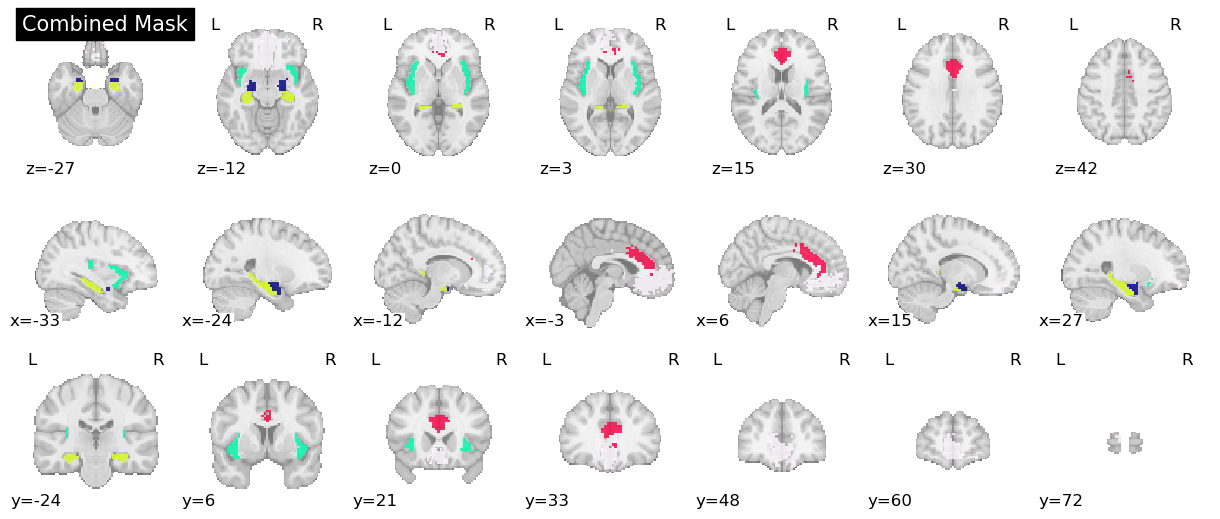

In [57]:
# run to load in previously-derived masks + create combined masker object (for ease of first-level computation)
from nilearn.maskers import NiftiLabelsMasker
from nibabel import Nifti1Image
from nilearn import plotting, masking

path = '/Volumes/Seagate Desktop Drive/NARSAD/roi_masks/anatomically-constrained'
os.chdir(path)

#making space defining image
sub = 'N234'
fmri_imgs = layout.get(subject=sub,
                        datatype='func',
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
space_defining_image = masking.compute_brain_mask(fmri_imgs[0])

amygdala = nib.load('amygdala.nii')
hippocampus = nib.load('hippocampus.nii')
insula = nib.load('insula.nii')
acc = nib.load('acc.nii')
vmpfc = nib.load('vmpfc.nii')

amygdala_data = amygdala.get_fdata() * 1
insula_data = insula.get_fdata() * 2
hippocampus_data = hippocampus.get_fdata() * 3
acc_data = acc.get_fdata() * 4
vmpfc_data = vmpfc.get_fdata() * 5

# Combine the masks by taking the maximum value at each voxel
combined_mask_data = np.maximum.reduce([
    amygdala_data,
    insula_data,
    hippocampus_data,
    acc_data,
    vmpfc_data
])

combined_mask_img = Nifti1Image(combined_mask_data, affine=insula.affine)
plotting.plot_roi(combined_mask_img, display_mode='mosaic',draw_cross=False, alpha=0.8, title="Combined Mask")

# First, initialize masker 
masker = NiftiLabelsMasker(
    combined_mask_img, mask_img=space_defining_image
)

## whole phase

### first level

In [58]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [59]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [60]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list()
        }

file_lists_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list()
        }

sub_order_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list()
        }

sub_order_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSR-CSS": (basic_contrasts["CSR"] - basic_contrasts["CSS"]),   
            "CSR-CS-": (basic_contrasts["CSR"] - basic_contrasts["CS-"]),   
            "CSS-CS-": (basic_contrasts["CSS"] - basic_contrasts["CS-"])
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.25761458 -0.81816107 -0.82933537 -0.80180931 -1.76191807]
CSR-CS-: Z-score outputs: [ 1.29993806  0.51372151 -0.26698542 -0.26973934 -1.77556236]
CSS-CS-: Z-score outputs: [0.97103786 1.3474015  0.60895171 0.57067683 0.04047339]
Subject N103 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.62221565  1.90946108  0.51893399  1.43347831  0.84728103]
CSR-CS-: Z-score outputs: [-1.15728436  0.2651334  -0.96013472  2.76760539  0.84618938]
CSS-CS-: Z-score outputs: [-0.42793173 -1.76908899 -1.46985345  1.19113281 -0.06708735]
Subject N104 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.43266647 -0.76568114 -1.58695407 -2.24230949 -2.62420735]
CSR-CS-: Z-score outputs: [-0.35871917 -0.40805973 -1.44525562 -0.15247669 -0.60841068]
CSS-CS-: Z-score outputs: [-0.79801346  0.41919525  0.33245442  2.21286316  2.16537667]
Subject N105 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.48243621  1.56861115 -0.88401976  1.67342968  1.15016499]
CSR-CS-: Z-score outputs: [0.65390124 2.18836509 0.37572141 1.52585835 0.40712422]
CSS-CS-: Z-score outputs: [ 1.16308736  0.40927359  1.33167184 -0.36082292 -0.86202312]
Subject N106 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.40815285  0.08743482 -0.29480709 -0.8060285  -0.95119689]
CSR-CS-: Z-score outputs: [ 1.03967673 -1.10481497 -2.6650418   1.06371865 -0.63568213]
CSS-CS-: Z-score outputs: [-0.50778094 -1.18747514 -2.32008472  1.90972242  0.38368707]
Subject N108 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.71870162 -1.02134681 -1.20360934  0.10741688  0.46522272]
CSR-CS-: Z-score outputs: [-2.01674099 -2.09530908 -3.18618977 -2.33362978 -2.26526253]
CSS-CS-: Z-score outputs: [-0.04053578 -0.91545109 -1.7359975  -2.37011488 -2.63192192]
Subject N109 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.32875466 0.17952125 0.24676221 0.6987016  0.6033797 ]
CSR-CS-: Z-score outputs: [0.88361719 0.59292214 0.11081246 0.88173289 0.53930084]
CSS-CS-: Z-score outputs: [-0.56800655  0.38834056 -0.15217929  0.12303055 -0.09291699]
Subject N110 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.44818771 -0.93256421 -1.606121   -0.23279257  0.07521454]
CSR-CS-: Z-score outputs: [-0.06519001 -0.73658276 -1.10896513 -1.25557131  0.44950574]
CSS-CS-: Z-score outputs: [ 0.42653339  0.30865752  0.66029123 -0.9670172   0.36178675]
Subject N111 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.58772372 1.44799907 2.52307476 1.5766485  1.46091255]
CSR-CS-: Z-score outputs: [ 0.45720234 -1.04676593  1.2682189   0.21341901  0.12876607]
CSS-CS-: Z-score outputs: [-0.19285585 -2.50391698 -1.46675238 -1.45151161 -1.40150306]
Subject N112 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.79129954  1.02262412 -0.22307373  1.0262842   0.74855749]
CSR-CS-: Z-score outputs: [-0.98993887 -1.12746782 -1.56326614 -0.07983789 -0.69898443]
CSS-CS-: Z-score outputs: [-0.10376177 -2.07555123 -1.22306339 -1.11965576 -1.4053454 ]
Subject N113 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.0118116  -0.98479148 -0.28012259 -0.36103414 -0.13375935]
CSR-CS-: Z-score outputs: [ 0.83848621  1.21050671 -1.20560053  0.49278172 -0.60563877]
CSS-CS-: Z-score outputs: [ 1.88831248  2.20214455 -0.86969216  0.85801366 -0.44631823]
Subject N114 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.67252702  1.60394378  1.22641365 -0.4422436   0.49577413]
CSR-CS-: Z-score outputs: [-0.57729296  0.32294704  0.52568151 -0.95829177  0.64404663]
CSS-CS-: Z-score outputs: [-1.28736046 -1.41762684 -0.80804557 -0.45872078  0.10001235]
Subject N115 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.28180885 -0.53884617 -1.7313067  -1.53826744 -1.16504403]
CSR-CS-: Z-score outputs: [-0.33401596 -0.40745292 -1.96441208  0.83802751 -0.09155388]
CSS-CS-: Z-score outputs: [-0.00975452  0.18984902 -0.01244658  2.50203661  1.1674464 ]
Subject N117 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.97661211 -0.53915841 -2.80483679  0.53984841  0.34791187]
CSR-CS-: Z-score outputs: [-1.16609789 -0.73532817 -1.82952298 -0.3031589  -0.42410185]
CSS-CS-: Z-score outputs: [ 2.06736947 -0.13436876  1.27235006 -0.85313691 -0.766643  ]
Subject N118 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.01018061 -0.08460425  0.57120736  0.1880278  -0.37557888]
CSR-CS-: Z-score outputs: [ 0.03274149  0.16705172  0.13085575  0.4973413  -0.42154003]
CSS-CS-: Z-score outputs: [ 0.02173683  0.25283988 -0.47032718  0.3004098  -0.0301498 ]
Subject N120 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.94888402  0.68268428 -0.52253416  0.02251188  0.00880648]
CSR-CS-: Z-score outputs: [ 0.58891397  0.96753138 -0.3036872   0.74326157  0.80612649]
CSS-CS-: Z-score outputs: [-0.4213846   0.24130487  0.25078956  0.70774388  0.79338902]
Subject N121 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.11702227  0.09195701  0.90084255 -0.45605336  1.2894325 ]
CSR-CS-: Z-score outputs: [0.01308597 1.21768748 1.4517378  1.44326407 2.52965141]
CSS-CS-: Z-score outputs: [1.19784503 1.09007892 0.45553755 1.89117137 1.19129221]
Subject N122 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.65574374  0.72690995 -1.70762679 -0.17932423  0.02230753]
CSR-CS-: Z-score outputs: [-0.65604532 -1.62951971 -1.88530198 -2.8910891  -1.64020549]
CSS-CS-: Z-score outputs: [ 1.11347509 -2.35473548 -0.02314781 -2.63307881 -1.64183543]
Subject N123 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.96812622 1.83464702 1.11764598 2.39965145 1.60294577]
CSR-CS-: Z-score outputs: [-1.39083704  3.24398003 -0.62705921  3.00556684 -0.67475489]
CSS-CS-: Z-score outputs: [-2.39295258  1.21445423 -1.84240889  0.40885205 -2.3697656 ]
Subject N124 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.87023891 -0.87492552  0.23573805 -0.76851631 -0.74813329]
CSR-CS-: Z-score outputs: [ 0.1653488  -0.68096157 -1.10405575 -0.51201802  0.01214735]
CSS-CS-: Z-score outputs: [-0.80417548  0.27401108 -1.37382899  0.32534861  0.82757249]
Subject N125 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.317444   -0.34927469  1.00280459 -0.27392655  1.94634143]
CSR-CS-: Z-score outputs: [-0.21202914  2.11256104 -0.48182316  2.9042036   3.41397367]
CSS-CS-: Z-score outputs: [-0.54159758  2.42107976 -1.52642051  3.10720165  1.30228158]
Subject N127 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.10219154 -1.19560182  1.09931731  0.21893383  0.63591678]
CSR-CS-: Z-score outputs: [ 0.12009527 -0.5129826   3.27982511  0.50585124  2.20844511]
CSS-CS-: Z-score outputs: [0.24108535 0.80408595 2.1665085  0.27727552 1.56862434]
Subject N128 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.15028495  0.65611951 -0.31546512  0.94347099  1.13901266]
CSR-CS-: Z-score outputs: [-1.02081209  3.16022666 -1.88582435  2.55145718  1.1765004 ]
CSS-CS-: Z-score outputs: [ 1.24432567  2.35881243 -1.49497816  1.46594531 -0.01972769]
Subject N129 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-3.06534167 -0.66098729 -1.86439079  0.42465249 -1.26377996]
CSR-CS-: Z-score outputs: [-1.85560037 -3.20018737 -0.29465193 -0.82445832  0.39226711]
CSS-CS-: Z-score outputs: [ 1.51937749 -2.38350616  1.68545199 -1.24687163  1.69225918]
Subject N130 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.2567163  -3.53568966 -2.9928432  -3.00304952 -4.18117829]
CSR-CS-: Z-score outputs: [-0.03391215 -1.90785086 -2.09420301 -2.04597496 -2.60347588]
CSS-CS-: Z-score outputs: [1.28603795 1.83292425 1.07690779 1.11899149 1.78235007]
Subject N131 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.79542261  0.96146117 -0.2727641   0.8985233   0.83585266]
CSR-CS-: Z-score outputs: [0.12443556 0.88767098 0.26505594 1.59710608 0.95005275]
CSS-CS-: Z-score outputs: [-0.75589347 -0.14819069  0.55862234  0.65028789  0.05631621]
Subject N132 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.92154671 -0.47815852  0.44900585  0.46854132  0.07989549]
CSR-CS-: Z-score outputs: [0.70448458 1.31910623 0.85627596 0.70289886 0.32439077]
CSS-CS-: Z-score outputs: [1.67667204 1.77289436 0.32019051 0.14163138 0.22491921]
Subject N133 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.58757063 -0.79461743 -2.62988444 -1.38150434 -1.37701834]
CSR-CS-: Z-score outputs: [-1.27788528  0.18908791 -1.76705427  0.20002246 -0.97474961]
CSS-CS-: Z-score outputs: [0.51223323 1.01605647 1.13569316 1.64142071 0.48924527]
Subject N134 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.37173541 -0.75573493  0.06070554  0.18863908 -0.75799289]
CSR-CS-: Z-score outputs: [ 0.87889946 -0.66031389  0.01977625 -0.84124246 -3.25450771]
CSS-CS-: Z-score outputs: [-0.64914057  0.15547321 -0.0455383  -0.99973898 -2.27006035]
Subject N135 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.09168523 -1.20698854 -1.28223861  0.91366668  1.17916776]
CSR-CS-: Z-score outputs: [-1.07314655 -0.86288898 -3.34067995 -1.54371204 -1.05582976]
CSS-CS-: Z-score outputs: [-0.94395928  0.44716933 -1.87003866 -2.48530644 -2.28307347]
Subject N136 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.21751281 2.12757708 0.03241111 1.51369663 0.0857588 ]
CSR-CS-: Z-score outputs: [-0.78686503  0.44231662 -0.88851375  1.37289858 -0.79316857]
CSS-CS-: Z-score outputs: [-0.97097757 -1.71804723 -0.88298584 -0.22232656 -0.84671807]
Subject N137 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.71363842  1.57683221 -0.67878678  0.2419142   0.76021835]
CSR-CS-: Z-score outputs: [-0.71963962  0.62469636 -0.47245976 -0.09015232 -0.35380443]
CSS-CS-: Z-score outputs: [ 1.20998532 -1.07335289  0.28958991 -0.35006451 -1.14393629]
Subject N138 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.01634449 -0.01813875 -1.62091826  0.30004675  0.1154289 ]
CSR-CS-: Z-score outputs: [-0.86215469  0.13653262 -1.62196041 -0.81492283 -1.7544162 ]
CSS-CS-: Z-score outputs: [ 0.23484896  0.15449983  0.09740922 -1.12510903 -1.87424924]
Subject N141 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.58584755 2.52660674 0.57872845 3.03582922 2.17598806]
CSR-CS-: Z-score outputs: [ 0.19753612  2.12208895 -0.17918882  2.76108777  1.65238027]
CSS-CS-: Z-score outputs: [-0.45342753 -0.66033779 -0.80241702 -0.55687066 -0.7077074 ]
Subject N142 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.50365523  0.01724502 -1.10140611 -0.56481326 -0.25136603]
CSR-CS-: Z-score outputs: [-0.65136766 -0.87204755 -1.02117583  0.28667723 -0.04828894]
CSS-CS-: Z-score outputs: [-0.08434688 -0.87599347  0.20597919  0.87344951  0.2204968 ]
Subject N143 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.22357497 -0.39399219 -0.50574722  0.18185564  0.64171766]
CSR-CS-: Z-score outputs: [ 0.88551729 -0.56146413 -0.38660639  0.84163653  1.75364013]
CSS-CS-: Z-score outputs: [-0.47971564 -0.11339537  0.17316948  0.6001006   0.99705507]
Subject N144 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.6336362   1.27755086 -0.42698406  0.12816466  0.40968204]
CSR-CS-: Z-score outputs: [ 1.0216609  -0.96971245  1.73046935 -1.36429767 -0.66681121]
CSS-CS-: Z-score outputs: [ 0.30662391 -2.3393732   2.16037317 -1.4753311  -1.10206762]
Subject N145 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.21776951 -0.16913836  0.31545504 -0.83100648 -1.38803495]
CSR-CS-: Z-score outputs: [-1.34338428  0.80926449 -0.96505259 -0.81746261 -2.42942914]
CSS-CS-: Z-score outputs: [-1.03395588  0.97966669 -1.28839512  0.12760521 -0.90123712]
Subject N146 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.37699822e-04 -1.78873543e+00 -1.09450165e+00 -1.85722099e+00
  9.70570093e-03]
CSR-CS-: Z-score outputs: [ 0.85363741 -2.87718505 -1.04976381 -2.29586252 -1.27345625]
CSS-CS-: Z-score outputs: [ 0.81505989 -0.95464705  0.12866924 -0.27759136 -1.23760412]
Subject N147 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-1.70375437  0.10269317 -0.61286299  0.75489222 -0.35702499]
CSR-CS-: Z-score outputs: [-0.24118794  1.71967666 -1.41562442  0.17592686 -0.55513607]
CSS-CS-: Z-score outputs: [ 1.58306039  1.60636549 -0.74592553 -0.61534337 -0.1768189 ]
Subject N148 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.64796973 -0.24518292 -0.10395211 -0.19994334  1.02990549]
CSR-CS-: Z-score outputs: [ 0.30638643  1.31265293 -0.19641419  0.31822165 -0.58244308]
CSS-CS-: Z-score outputs: [-0.38867955  1.5460968  -0.08010979  0.52233879 -1.64735895]
Subject N149 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.66204456 -2.71364556  0.3585115  -1.47921952 -0.0228733 ]
CSR-CS-: Z-score outputs: [-0.13073075 -0.39170959 -1.83937142 -1.05885166 -4.06379849]
CSS-CS-: Z-score outputs: [ 1.71414462  2.55725804 -2.20683229  0.55855929 -4.0376391 ]
Subject N150 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-0.41522182 -1.74333466 -1.31853128 -2.96078871 -2.78209154]
CSR-CS-: Z-score outputs: [ 0.50413773 -2.54884954  0.02522166 -1.89647162 -0.87981492]
CSS-CS-: Z-score outputs: [ 0.90587322 -0.70125603  1.37302512  1.21496446  1.99373828]
Subject N151 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.1333396  1.26843118 0.50852114 1.69934644 1.31894227]
CSR-CS-: Z-score outputs: [0.69723054 2.96019824 1.01636263 2.76221121 1.85840587]
CSS-CS-: Z-score outputs: [0.52822589 1.469714   0.42997795 0.86429578 0.41656363]
Subject N153 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.31334296  0.2372886   0.10241311 -1.29948176 -0.70881174]
CSR-CS-: Z-score outputs: [-0.79330596  1.28837041  0.58567055  1.1862271   0.20921101]
CSS-CS-: Z-score outputs: [-0.42084112  0.99003256  0.45018541  2.51888472  0.95456633]
Subject N154 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.80035384  0.32503877 -0.46924582  1.16871717  0.76223813]
CSR-CS-: Z-score outputs: [-1.81815193  0.96301456 -1.18083186  1.57858221  0.37879902]
CSS-CS-: Z-score outputs: [-0.93284553  0.61209361 -0.66389165  0.3196411  -0.43528936]
Subject N155 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.2590727   1.36222055 -1.5504445   0.29007211 -2.23602111]
CSR-CS-: Z-score outputs: [-1.23073476  0.78693637 -0.9560964   0.66435237 -0.50783994]
CSS-CS-: Z-score outputs: [ 0.18742653 -0.65267236  0.73518395  0.34408373  1.83057015]
Subject N156 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.22352749 -0.77189754 -3.44472945 -1.11662335 -1.20842647]
CSR-CS-: Z-score outputs: [-0.87803222 -0.99484554 -2.05123271 -1.92766628 -1.89652418]
CSS-CS-: Z-score outputs: [ 1.46745801 -0.15160026  1.60922903 -0.69482495 -0.6113281 ]
Subject N157 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.53657062  1.08357473  0.45928417 -0.14587657  0.42845022]
CSR-CS-: Z-score outputs: [0.75105958 0.89476202 0.09009758 0.81727736 0.69127138]
CSS-CS-: Z-score outputs: [-0.93716447 -0.29670686 -0.40205493  0.91581127  0.19617638]
Subject N158 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.14535145 -0.34432796 -1.59350892 -0.70468193 -0.26775038]
CSR-CS-: Z-score outputs: [-0.5677429   0.05868194 -2.33585568 -1.03212855 -2.74024676]
CSS-CS-: Z-score outputs: [-0.38483633  0.4235246  -0.55463891 -0.25532927 -2.41136164]
Subject N202 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.37008817  1.51975823  0.55746513  1.04187633  1.14734397]
CSR-CS-: Z-score outputs: [-0.09496212 -0.92194969  0.49142593  0.38589106  0.04917782]
CSS-CS-: Z-score outputs: [ 0.3067446  -2.48976037 -0.1133211  -0.71817895 -1.15550812]
Subject N203 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.16328373 -1.45557856 -1.87507241 -1.26976594 -0.43248551]
CSR-CS-: Z-score outputs: [-0.12111905 -0.93208155 -2.64665849 -1.49829147 -0.78880413]
CSS-CS-: Z-score outputs: [-0.29073005  0.66998178 -0.47487632 -0.04314046 -0.29032315]
Subject N204 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.46227624 -1.36609806 -1.1110447   0.69032126 -1.79875788]
CSR-CS-: Z-score outputs: [0.88605333 1.42096573 1.85368966 2.08254252 0.8956015 ]
CSS-CS-: Z-score outputs: [2.4078107  2.80576307 2.96525742 1.32639666 2.72325317]
Subject N206 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.86516628 -0.07403841 -1.3497642   0.66187156  0.26695063]
CSR-CS-: Z-score outputs: [-2.72588902 -0.32566155 -2.02408446 -0.24442034 -0.27394796]
CSS-CS-: Z-score outputs: [-0.59270785 -0.23953051 -0.50133341 -0.94567223 -0.55706837]
Subject N207 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.18111652 -0.50244332 -0.24458057 -0.66398812 -1.10825256]
CSR-CS-: Z-score outputs: [ 2.66091545 -0.1828887   0.03214755  0.23289284 -1.07259113]
CSS-CS-: Z-score outputs: [2.34437365 0.35678398 0.29500121 0.94217431 0.1574377 ]
Subject N209 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.61037628 -0.43802297 -0.74030567  0.91079081  1.76852103]
CSR-CS-: Z-score outputs: [-1.26208616  4.09216262 -2.86264437  4.98391453  0.53329903]
CSS-CS-: Z-score outputs: [ 0.54904562  4.32672059 -1.88470683  3.7825529  -1.32997726]
Subject N210 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.54789174 -0.92660961 -1.39691568 -1.12621621 -1.59927637]
CSR-CS-: Z-score outputs: [-0.18751695 -1.38761577 -2.5140725  -1.0923671  -1.97367779]
CSS-CS-: Z-score outputs: [ 0.40885799 -0.39877575 -0.99936715  0.08780133 -0.31560351]
Subject N211 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.44502769 -0.19519567  0.19003836 -1.35253116  0.02160806]
CSR-CS-: Z-score outputs: [ 1.1952728   2.28803198 -0.81941257  1.46476581  0.17036637]
CSS-CS-: Z-score outputs: [-0.41712195  2.42882379 -0.99748045  2.83672157  0.14546386]
Subject N212 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.61283903  2.98969966 -0.18906732  1.24316316  0.23824181]
CSR-CS-: Z-score outputs: [1.21994596 2.72844483 2.24879887 1.63153881 2.53258237]
CSS-CS-: Z-score outputs: [ 0.5579072  -0.48051041  2.4808727   0.32643381  2.32887919]
Subject N213 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.06920383  0.59734976 -0.88017125  0.76408081 -0.79883059]
CSR-CS-: Z-score outputs: [ 0.35354069 -0.39801052 -0.18562279  1.55496224  0.86697749]
CSS-CS-: Z-score outputs: [ 1.46669754 -1.00208624  0.74172123  0.72905875  1.67297037]
Subject N214 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.47093926  1.48676201 -2.91372279  0.24273528 -4.51749665]
CSR-CS-: Z-score outputs: [-2.42559741  2.06640858 -4.07730017  0.24226895 -4.75329558]
CSS-CS-: Z-score outputs: [ 0.33632623  0.41368645 -0.81540394 -0.02873804  0.23730601]
Subject N215 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.08321085  1.05836914  0.98669926 -0.36755853  0.45261835]
CSR-CS-: Z-score outputs: [ 1.26063737  0.62558383  1.82641437  0.13869601 -0.65128708]
CSS-CS-: Z-score outputs: [ 0.08852153 -0.4955987   0.71134958  0.51701479 -1.10037008]
Subject N216 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 3.0874637  -0.83858463  0.23271041 -1.20308044 -0.03959754]
CSR-CS-: Z-score outputs: [ 1.15373018 -0.38698457  0.09529402 -0.80103955 -0.19487054]
CSS-CS-: Z-score outputs: [-2.03246572  0.47223173 -0.14362087  0.45159027 -0.14768471]
Subject N217 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.37062981 -0.74640902 -1.41108987  1.42786699  0.7990771 ]
CSR-CS-: Z-score outputs: [-1.12198813  0.55393361 -1.48006132  2.06486953  1.52908729]
CSS-CS-: Z-score outputs: [-0.716207    1.33129489 -0.0067746   0.56004479  0.67795968]
Subject N219 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.59079207 -2.55357088 -0.68695359 -0.27517813 -1.46090731]
CSR-CS-: Z-score outputs: [-0.90937101  1.28642013  1.40944524  2.44911431  0.94609159]
CSS-CS-: Z-score outputs: [0.84629585 3.96102198 2.11396689 2.67513955 2.48423218]
Subject N220 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.13762316  2.41082862  0.50571366  1.25418784  1.43652516]
CSR-CS-: Z-score outputs: [0.35702684 1.49519807 1.22406919 1.67062219 0.46385468]
CSS-CS-: Z-score outputs: [ 0.48659676 -1.11424595  0.64346051  0.2924969  -1.05976701]
Subject N221 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.01785149 -0.56074782  0.75480794  0.552824   -0.34657677]
CSR-CS-: Z-score outputs: [-0.532932   -0.40503447 -0.77983708 -0.38705286  0.0679926 ]
CSS-CS-: Z-score outputs: [-0.49985364  0.20640187 -1.59593811 -0.96322551  0.42492683]
Subject N222 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.71170892 -0.37947381 -2.1022463  -0.19879364 -0.41244953]
CSR-CS-: Z-score outputs: [-1.59641517  1.1388705  -3.0235355   0.31282707 -1.9452759 ]
CSS-CS-: Z-score outputs: [-0.72771643  1.49899733 -0.58249305  0.51752238 -1.45666409]
Subject N224 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.76711765  0.06603236 -0.32545069  1.92779518  0.05280293]
CSR-CS-: Z-score outputs: [-1.29877236 -0.32329097 -1.00086704  0.37867121 -0.93059775]
CSS-CS-: Z-score outputs: [-0.4404726  -0.38783204 -0.62362056 -1.72741583 -0.97067457]
Subject N225 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.00129131  0.00212203 -0.130318   -0.4227272   0.93046697]
CSR-CS-: Z-score outputs: [-1.47908633  2.05430716 -0.88477674  1.47110387  0.28592544]
CSS-CS-: Z-score outputs: [-1.43119715  2.0027598  -0.7194914   1.89044083 -0.71944827]
Subject N226 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.4928072  1.74660465 1.08591565 0.85335558 0.89796064]
CSR-CS-: Z-score outputs: [-2.94731043  1.18413699 -1.88835395 -0.02590086 -0.10955518]
CSS-CS-: Z-score outputs: [-3.38779753 -0.65973105 -2.97307367 -0.91156331 -1.03442404]
Subject N227 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.62191826  1.72152502 -1.87792674  1.58336731  0.20799642]
CSR-CS-: Z-score outputs: [-1.9225982  -0.87627065 -1.93533477  0.72026753 -0.81991895]
CSS-CS-: Z-score outputs: [-1.19514231 -2.6318703   0.08635527 -0.97407884 -1.01783912]
Subject N228 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.00964712 -1.45457195 -1.71243368 -1.75466523 -0.75891664]
CSR-CS-: Z-score outputs: [-0.16876058 -0.07549117 -0.82998421 -0.23253793 -0.87497139]
CSS-CS-: Z-score outputs: [ 0.96913205  1.47703369  1.06337114  1.66626905 -0.06233361]
Subject N230 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.85565156 -0.69451646  0.16691008 -0.11587915  0.17502246]
CSR-CS-: Z-score outputs: [-0.18012921 -2.9864031  -0.51201963 -2.2600449  -0.64205065]
CSS-CS-: Z-score outputs: [-1.11842077 -2.27933844 -0.69395427 -2.14905392 -0.83257274]
Subject N231 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.71860286  0.951651   -2.25888273  1.67276935 -1.08335149]
CSR-CS-: Z-score outputs: [-1.19367335  1.37891849 -1.96721393  1.90780753 -2.30325333]
CSS-CS-: Z-score outputs: [-0.35899871  0.32927273  0.54318063  0.10293783 -1.13609106]
Subject N232 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.20401396  1.47397141  1.26076255  0.80172386  0.95749218]
CSR-CS-: Z-score outputs: [0.47269997 2.36962327 0.95788205 0.99599145 1.35101613]
CSS-CS-: Z-score outputs: [ 0.67883502  0.79863124 -0.39033059  0.1393875   0.33352993]
Subject N233 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.04505822  1.05585259 -0.30291856  0.98005874 -1.11985543]
CSR-CS-: Z-score outputs: [ 0.8518301   0.4802716  -1.24809312  1.50008331 -1.21590243]
CSS-CS-: Z-score outputs: [-0.28654177 -0.68169439 -0.95787642  0.46344969 -0.02125905]
Subject N234 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.19550021  0.61712013 -0.22638049  0.94966638  0.1940462 ]
CSR-CS-: Z-score outputs: [2.79826087 2.08828388 0.7924445  2.09367292 0.53129557]
CSS-CS-: Z-score outputs: [2.91233123 1.38520299 1.01116497 1.03496757 0.3098744 ]
Subject N235 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.82233114 -0.63574854 -0.41169731  0.02449831  0.21296102]
CSR-CS-: Z-score outputs: [-0.10453729  0.86073927 -1.08061269  0.43545628 -1.48040791]
CSS-CS-: Z-score outputs: [ 0.77811809  1.48677032 -0.58569086  0.38905237 -1.64603389]
Subject N236 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.37898781  0.57846904  1.05644813  0.65720881 -1.8265989 ]
CSR-CS-: Z-score outputs: [ 1.62298126  0.64493676  0.07866576  0.35706226 -3.02049875]
CSS-CS-: Z-score outputs: [ 0.08702778  0.01030898 -1.11458382 -0.37028628 -1.0166221 ]
Subject N237 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.04075352 -0.96707359  0.09128376  0.37567396  1.50320212]
CSR-CS-: Z-score outputs: [ 0.75908071 -0.94351626  1.60120135 -0.11538856  2.03637699]
CSS-CS-: Z-score outputs: [ 0.70357789  0.09810136  1.4884513  -0.51078063  0.43471915]
Subject N238 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.41514907 -3.05167489 -2.72483991 -1.51691707 -2.02732871]
CSR-CS-: Z-score outputs: [-1.80117718 -1.50153208 -2.24656853  0.30476213 -0.60375698]
CSS-CS-: Z-score outputs: [0.86482791 1.76820662 0.71486823 1.91034705 1.58058173]
Subject N240 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.00671703 -0.21623238 -2.40913198 -0.00455103 -1.49574848]
CSR-CS-: Z-score outputs: [-1.41278986  1.57775785 -1.73818224  1.01990306 -2.37055075]
CSS-CS-: Z-score outputs: [ 0.80338828  1.80342545  0.86714625  1.02147909 -0.75330297]
Subject N241 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.13030447 -0.99415884  4.02541441 -1.96091247  0.27101164]
CSR-CS-: Z-score outputs: [1.32594397 0.67962339 2.90760266 0.08302822 0.54642547]
CSS-CS-: Z-score outputs: [ 0.06975696  1.7097723  -1.57369478  2.15615332  0.23448571]
Subject N242 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.07265768 -1.21481185 -0.56724312 -1.63438867 -0.64567385]
CSR-CS-: Z-score outputs: [-2.5717494   0.36748903 -0.14331058  0.45505322 -1.42797363]
CSS-CS-: Z-score outputs: [-2.35296483  1.58653388  0.44054691  2.09637562 -0.743923  ]
Subject N243 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.62108949 1.81721805 2.76626939 4.05775893 3.83519645]
CSR-CS-: Z-score outputs: [-0.11944433  0.55591411 -1.61625342  1.43853586  0.10422584]
CSS-CS-: Z-score outputs: [-1.88425972 -1.4032318  -4.52131688 -2.98046991 -4.01577806]
Subject N244 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.04580181  0.68922424 -0.59979728  1.16047083 -0.62434877]
CSR-CS-: Z-score outputs: [ 0.35476447  1.65979889 -1.4057144   2.10032118 -0.49686833]
CSS-CS-: Z-score outputs: [ 0.38815034  0.90555554 -0.72958943  0.84939764  0.149479  ]
Subject N246 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.04280791 -1.3736449  -0.65900665 -2.14514683 -0.72739762]
CSR-CS-: Z-score outputs: [ 0.30327584 -0.24286579  0.5058233  -0.53520591  0.98957258]
CSS-CS-: Z-score outputs: [1.43845811 1.24693517 1.21364194 1.81766392 1.76418644]
Subject N247 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.79222107  0.39680327  0.68686687 -0.00643543 -1.7164631 ]
CSR-CS-: Z-score outputs: [ 0.39381654 -0.59397134 -0.18650164 -1.2936138  -0.43205393]
CSS-CS-: Z-score outputs: [-0.49207133 -1.00721997 -0.93260036 -1.23745193  1.44047846]
Subject N248 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.75588862 -0.58872485  0.60399181  0.29575716  1.00393721]
CSR-CS-: Z-score outputs: [-1.20194028  0.87022864  1.78869427  2.13462828  3.08938782]
CSS-CS-: Z-score outputs: [-0.34254431  1.49171775  1.08569415  1.80164046  2.03222374]
Subject N249 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.16976968 -0.77011253  1.50494583  1.29964109  1.354139  ]
CSR-CS-: Z-score outputs: [ 0.23024891 -1.89271329  1.93522386 -0.88305475  0.5569076 ]
CSS-CS-: Z-score outputs: [ 0.03865309 -1.05025869  0.21238484 -2.20331799 -0.8526066 ]
Subject N250 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.97522221 -0.80949282 -2.31140095 -0.71770783 -3.51408633]
CSR-CS-: Z-score outputs: [-1.72355017  0.20422711 -3.93462721  0.58219529 -2.2864556 ]
CSS-CS-: Z-score outputs: [ 0.47340138  1.06691513 -1.33567497  1.33926618  1.55279079]
Subject N251 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.11501491 -1.12990473 -0.7111518  -0.21785934 -0.60823956]
CSR-CS-: Z-score outputs: [-1.77647834 -0.19266884 -0.45059593 -0.18906483 -0.54409246]
CSS-CS-: Z-score outputs: [-1.76027783  0.98941231  0.32853271  0.0500417   0.10172131]
Subject N252 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.81854607 -1.43541243 -2.15431073 -0.98510262 -0.70291869]
CSR-CS-: Z-score outputs: [-1.00972833 -0.09212905 -1.65861348  0.1473221  -0.13280264]
CSS-CS-: Z-score outputs: [-0.04404027  1.39888304  0.7299518   1.15894341  0.60275625]
Subject N253 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.7734163   1.8405167  -1.14494936  3.48265529  2.85844084]
CSR-CS-: Z-score outputs: [-1.8829271   0.02053001 -2.44452385  2.73898344  1.49717918]
CSS-CS-: Z-score outputs: [-1.07697112 -1.90585334 -1.23351656 -0.92411309 -1.50683998]
Subject N254 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.44338415  0.79130324 -0.59946603 -0.91595832 -1.66518945]
CSR-CS-: Z-score outputs: [ 1.6621887   2.42684336  0.55552144  1.82619669 -0.17803631]
CSS-CS-: Z-score outputs: [0.06515845 1.54823053 1.17260006 2.71869379 1.55094597]
Subject N255 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.15035141 -0.93226372 -0.88010276 -0.51386289 -0.28553208]
CSR-CS-: Z-score outputs: [ 0.27984934 -0.74578793 -1.38303423 -1.32564039 -0.63360805]
CSS-CS-: Z-score outputs: [ 0.10900492  0.25020015 -0.41113433 -0.74709927 -0.32506233]
Subject N257 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(


CSR-CSS: Z-score outputs: [-0.63544304  1.8590283  -1.06015335  0.85934244 -1.69199361]
CSR-CS-: Z-score outputs: [-0.75899904  0.8844067  -0.05039688  0.10915787 -1.83060657]
CSS-CS-: Z-score outputs: [-0.11667049 -1.0390286   1.05697483 -0.78658001 -0.11642773]
Subject N258 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.54409007 -0.20891884  0.07860892 -0.09662129 -0.66087107]
CSR-CS-: Z-score outputs: [ 2.48231868 -0.8741622  -0.50630674 -1.46796447 -0.40808874]
CSS-CS-: Z-score outputs: [-0.29314047 -0.63075825 -0.5737232  -1.34147866  0.27163813]
Subject N259 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
US_CSS, US_CSR.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.50881619  1.22879446 -0.60426863  1.33692212 -0.07269879]
CSR-CS-: Z-score outputs: [ 0.07597276  2.79114254 -1.20955152  1.30011874 -1.78777901]
CSS-CS-: Z-score outputs: [ 1.70101395  1.40717438 -0.56587976 -0.1430713  -1.69677681]
Subject N260 completed for phase2!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.83536431  1.38761601 -0.8697355   2.4077265   1.31205866]
CSR-CS-: Z-score outputs: [ 0.19624219  0.48585896 -0.64741298  1.14329068  1.58844955]
CSS-CS-: Z-score outputs: [ 0.98568672 -0.86694934  0.22530803 -1.22847345  0.25974266]
Subject N101 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.69129016  0.99627374 -0.40635698  0.82907835 -1.41418726]
CSR-CS-: Z-score outputs: [-0.98769897  1.57715733 -1.36451602  1.09434613 -1.31901949]
CSS-CS-: Z-score outputs: [-0.28775442  0.57058439 -0.92479364  0.26443261  0.05126786]
Subject N103 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.81693521 -0.42331121  0.25022526 -0.11980381  0.70411499]
CSR-CS-: Z-score outputs: [ 0.0609338  -0.15012264  0.92102219  0.31452293  0.22134286]
CSS-CS-: Z-score outputs: [ 0.82118821  0.24694477  0.69626084  0.42707558 -0.43986986]
Subject N104 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.66273833 -0.70818673 -2.98878061 -0.37778903 -1.56726751]
CSR-CS-: Z-score outputs: [-0.81932798  1.15212442 -1.99163812  0.57253312 -0.3990731 ]
CSS-CS-: Z-score outputs: [-0.15788775  1.83466412  1.0024805   0.93838029  1.135351  ]
Subject N105 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.91739967 -0.2678073  -0.673926   -1.7338664   0.24332387]
CSR-CS-: Z-score outputs: [-0.11000084 -1.23788409 -1.72938875 -1.06100086 -0.09585949]
CSS-CS-: Z-score outputs: [ 0.77221027 -1.00965518 -1.11678424  0.57841867 -0.33282285]
Subject N106 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.72097945  1.17357004 -0.25021209  1.89463369  0.70176314]
CSR-CS-: Z-score outputs: [ 0.43879018  1.09673362 -0.73960957  2.0942751  -0.02041982]
CSS-CS-: Z-score outputs: [-0.2421434  -0.02522656 -0.48828005  0.28158269 -0.67847655]
Subject N108 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.64427363  0.53058238 -1.20870796  0.69770801 -0.48262373]
CSR-CS-: Z-score outputs: [-2.85070572  0.1646824  -2.90587212 -1.33414497 -2.79547381]
CSS-CS-: Z-score outputs: [-2.25132363 -0.34259384 -1.76724418 -1.99088264 -2.32902751]
Subject N109 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.52273027  0.37226503  0.50532609 -0.33284613 -0.95824178]
CSR-CS-: Z-score outputs: [-0.56732681  0.34150459 -0.07880858  0.16577211 -0.71968839]
CSS-CS-: Z-score outputs: [-1.06382979 -0.01124791 -0.55883104  0.48224058  0.18947022]
Subject N110 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.39912534  3.03560175 -1.6295448   1.74634396 -3.64640512]
CSR-CS-: Z-score outputs: [-0.38976132  2.60974452 -1.45268211  1.62299982 -3.41750493]
CSS-CS-: Z-score outputs: [-0.81038977 -0.37741162  0.14614303 -0.08683277  0.14848838]
Subject N111 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.48424996 -1.17795566  0.34603678 -0.33190569  1.11075923]
CSR-CS-: Z-score outputs: [-1.25840716 -0.94918354 -1.28484696 -1.44570997 -0.34804919]
CSS-CS-: Z-score outputs: [ 0.15541701  0.16860966 -1.67340681 -1.16903877 -1.44265845]
Subject N112 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.48538857  2.52882587  1.92921419 -0.38085345 -0.63995062]
CSR-CS-: Z-score outputs: [ 0.52872766 -0.4804104   1.08082671 -1.76514228 -0.15850619]
CSS-CS-: Z-score outputs: [-0.93366195 -2.92419279 -0.82775618 -1.35245736  0.46874162]
Subject N113 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.63245882 -1.36924651 -1.38738853 -0.98679028 -1.99248001]
CSR-CS-: Z-score outputs: [ 1.81180081  0.985344   -0.80921423  1.80122961 -0.60310144]
CSS-CS-: Z-score outputs: [2.32645651 2.25253711 0.52433834 2.67771253 1.3046256 ]
Subject N114 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.78176394  1.11155714 -1.70985832  0.59359203  0.62869251]
CSR-CS-: Z-score outputs: [-1.24012976  0.60002093 -0.6014309  -0.15289395  0.7526313 ]
CSS-CS-: Z-score outputs: [-0.49276223 -0.46513721  1.03810742 -0.72138363  0.15095878]
Subject N115 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.83153683  0.17418096  0.58316729  0.18867074 -0.46948692]
CSR-CS-: Z-score outputs: [ 0.37724998  1.13195737 -0.60147188  0.72023083 -1.15530382]
CSS-CS-: Z-score outputs: [-0.41329588  0.94517124 -1.12534569  0.52663625 -0.68162945]
Subject N117 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.91663003 1.3439319  0.59462951 0.92987904 2.44417704]
CSR-CS-: Z-score outputs: [ 0.09638692  0.97925661 -0.41299332  0.85528006  0.23358931]
CSS-CS-: Z-score outputs: [-0.76836836 -0.29841835 -0.96913764 -0.03036394 -2.08491491]
Subject N118 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.24519549  1.39019099 -1.21567663  2.11959478 -0.55487367]
CSR-CS-: Z-score outputs: [ 0.4081675   1.63941733 -1.92372456  0.93931167 -2.81321923]
CSS-CS-: Z-score outputs: [ 0.63259785  0.29698551 -0.74729464 -1.08806561 -2.25557669]
Subject N121 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.41586776  0.42799425 -1.57406193 -0.06211345 -2.02832946]
CSR-CS-: Z-score outputs: [-1.31374728  0.36832171 -1.81343953 -0.27184675 -1.91403063]
CSS-CS-: Z-score outputs: [-0.88229565 -0.04725156 -0.26611295 -0.20864653  0.05075481]
Subject N122 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.00251585  0.44751635  1.27295854  0.79537767  1.07515777]
CSR-CS-: Z-score outputs: [-0.60244754  0.23257173  0.49189644  1.14944076  1.46456715]
CSS-CS-: Z-score outputs: [-0.58429212 -0.19842659 -0.73428242  0.37954574  0.44597125]
Subject N123 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.69154228  1.76567212  0.74575167  1.09906734  1.5490632 ]
CSR-CS-: Z-score outputs: [ 0.34760329  0.2940913   0.37182927 -0.95049433 -0.60332955]
CSS-CS-: Z-score outputs: [ 1.91736124 -1.37913255 -0.3504117  -1.95580452 -2.0477673 ]
Subject N124 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.68097328  1.04361636 -3.13702752  2.60482829  0.19906625]
CSR-CS-: Z-score outputs: [-2.82137749  1.45103679 -4.05577066  2.51829647 -0.08552571]
CSS-CS-: Z-score outputs: [-2.34581216  0.51953067 -1.25251045  0.12932017 -0.28318153]
Subject N125 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.44423061 2.81288211 1.45423817 2.06655362 1.35738926]
CSR-CS-: Z-score outputs: [-0.31154416  0.87543093 -1.4819264   0.54990161 -0.75289879]
CSS-CS-: Z-score outputs: [-1.69708095 -1.8705869  -2.83699909 -1.46096181 -2.04026362]
Subject N127 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.0880149  -1.08137159  1.95954838  0.44382061  0.9546772 ]
CSR-CS-: Z-score outputs: [ 0.41468383 -0.23422401  1.23232394  1.9616415   1.73630736]
CSS-CS-: Z-score outputs: [-0.62428131  0.79703202 -0.63507137  1.55211331  0.82969245]
Subject N128 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.3048902   0.74983641 -0.17289401  1.74032389  0.05846907]
CSR-CS-: Z-score outputs: [ 1.19000038 -0.01531711 -1.12761766  0.34349904 -0.84536379]
CSS-CS-: Z-score outputs: [ 0.88478931 -0.69972348 -0.94115015 -1.24510825 -0.88061003]
Subject N129 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.40088596 -1.24963758 -0.17640855 -1.26788154 -2.14855423]
CSR-CS-: Z-score outputs: [-0.86535997 -1.89597828  0.01400053 -2.00177813 -1.61596459]
CSS-CS-: Z-score outputs: [ 0.439984   -0.72099725  0.17913818 -0.80614409  0.42113698]
Subject N130 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-3.49455424 -1.03736109 -1.87401215 -1.73655381 -1.69366762]
CSR-CS-: Z-score outputs: [-4.16386694 -1.77631149 -3.59010102 -0.87466075 -1.52907863]
CSS-CS-: Z-score outputs: [-0.75286855 -0.75337022 -1.75751902  0.80917007  0.12192474]
Subject N131 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.94042014  0.80685539  0.82353109  0.9526584  -0.47785097]
CSR-CS-: Z-score outputs: [ 0.49226425 -1.77896446 -0.76911619 -0.72241803 -0.74459541]
CSS-CS-: Z-score outputs: [-1.34612417 -2.47144114 -1.52594107 -1.58057919 -0.28798249]
Subject N132 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 2.3354504  -1.47433296  1.22574034 -1.72412799 -0.24383821]
CSR-CS-: Z-score outputs: [ 1.43792346 -1.38272829  0.78872523 -1.75488905 -1.31646023]
CSS-CS-: Z-score outputs: [-0.76285698  0.01208286 -0.36414904 -0.1218992  -1.08074383]
Subject N133 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [-0.226765    2.97945606 -0.61360988  2.80233296  1.71493393]
CSR-CS-: Z-score outputs: [-0.0170454   1.92483709 -1.00105855  1.10558885  1.76684352]
CSS-CS-: Z-score outputs: [ 0.19231998 -0.91497152 -0.3915855  -1.53952161  0.1151369 ]
Subject N134 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.98943397  2.11857278  1.31992112  2.03216535 -0.61715192]
CSR-CS-: Z-score outputs: [ 0.3428699  -1.15496482  0.3575341  -2.23438699 -2.85599522]
CSS-CS-: Z-score outputs: [-0.64617138 -3.08742098 -0.9481563  -3.96339551 -2.0206243 ]
Subject N135 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.24690244 -0.36140954  1.19542539  0.6258405   1.03059245]
CSR-CS-: Z-score outputs: [0.10616401 0.69569034 1.30297445 2.48311187 2.13675648]
CSS-CS-: Z-score outputs: [-0.13501968  1.0268131   0.11960466  1.81097038  1.11656626]
Subject N136 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.02739116 -0.46755708 -0.60188312  0.59980647  0.56383134]
CSR-CS-: Z-score outputs: [ 1.29265843 -1.69253553  1.22747218  0.03515829  1.44763275]
CSS-CS-: Z-score outputs: [ 2.25220573 -1.25388095  1.793505   -0.53073291  0.91456094]
Subject N137 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.27857984 -1.99462416  0.6274843  -0.95759002  0.76012881]
CSR-CS-: Z-score outputs: [1.39800673 0.13336729 0.77649029 0.43025525 0.64320165]
CSS-CS-: Z-score outputs: [ 1.12441864  1.97131755  0.19388323  1.30252934 -0.06311757]
Subject N138 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.49183321 -0.67973047  0.12828682 -1.34631829  0.17912997]
CSR-CS-: Z-score outputs: [-1.39751938 -1.22679519 -0.78774086 -1.62683045 -0.29835667]
CSS-CS-: Z-score outputs: [-0.98059655 -0.60822855 -0.92766999 -0.37835459 -0.47192937]
Subject N141 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.47075738 -2.89842904 -2.74888849 -2.34632978 -1.67413685]
CSR-CS-: Z-score outputs: [-0.23476645 -2.26556572 -0.95582402 -2.01221701  0.02244162]
CSS-CS-: Z-score outputs: [1.1467189  0.51467303 1.65608132 0.23273755 1.60205248]
Subject N142 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.87052459  0.40810919  0.83310558 -0.35919673 -0.67961739]
CSR-CS-: Z-score outputs: [1.56624322 1.08184948 0.66464676 2.0131122  1.94510851]
CSS-CS-: Z-score outputs: [-0.21927801  0.70525075 -0.13166089  2.38848024  2.62453937]
Subject N143 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.28681793 -1.10237795  0.65335401  0.27866949 -0.18726202]
CSR-CS-: Z-score outputs: [-0.16151132 -1.58082408  0.10485843  0.52214045  2.65206589]
CSS-CS-: Z-score outputs: [-0.41525885 -0.561513   -0.48329508  0.26121433  2.77083707]
Subject N144 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.87469528 -0.66672466 -1.26284904 -0.20054222 -0.43042045]
CSR-CS-: Z-score outputs: [-0.23703841 -1.97649691  0.98962782 -1.09087525 -0.02575421]
CSS-CS-: Z-score outputs: [ 0.60986873 -1.35474607  2.19702801 -0.9084932   0.39168989]
Subject N145 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.84572485 1.66103551 2.04926062 0.32453718 1.17868364]
CSR-CS-: Z-score outputs: [1.65389086 1.54368213 0.398401   1.84165065 1.66145716]
CSS-CS-: Z-score outputs: [-1.07370968 -0.06397401 -1.53669283  1.48356759  0.50670793]
Subject N146 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.30862064  0.23623066  0.47963247  0.03356802  0.49244193]
CSR-CS-: Z-score outputs: [-0.09712231  1.66268729 -0.93696725  1.56212116 -1.10357713]
CSS-CS-: Z-score outputs: [ 0.20000668  1.4098765  -1.3728513   1.49682752 -1.55869548]
Subject N147 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.8324687  -0.84954777  2.35508661 -0.28322124 -0.6756374 ]
CSR-CS-: Z-score outputs: [ 0.68021925  0.19256738  1.65951946  0.48112516 -1.32415571]
CSS-CS-: Z-score outputs: [-0.10971514  1.00006529 -0.58359779  0.75080699 -0.68197831]
Subject N148 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.10242841  0.7726025  -0.25829888  0.96067871  0.19807424]
CSR-CS-: Z-score outputs: [ 1.08166084  0.26078098  1.04294785 -0.52225586 -0.39242571]
CSS-CS-: Z-score outputs: [ 0.97517109 -0.48355663  1.28555171 -1.43814126 -0.57915898]
Subject N149 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.13770747  0.49386376  0.49993861  0.46555882 -1.7534369 ]
CSR-CS-: Z-score outputs: [-1.64568477 -0.32767369 -2.04278449  0.3494951  -0.98747211]
CSS-CS-: Z-score outputs: [-1.72971656 -0.78284055 -2.44340867 -0.09283131  0.67537508]
Subject N150 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.15036723  0.15369167  0.95308633 -1.48303587 -0.34215275]
CSR-CS-: Z-score outputs: [-0.79398072 -1.62040947 -0.89349233 -1.93574754 -3.27299919]
CSS-CS-: Z-score outputs: [-1.79161546 -1.70352513 -1.71174667 -0.49367164 -2.81238604]
Subject N151 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.40477041  0.18946887 -0.76446194 -1.77565576 -0.65288588]
CSR-CS-: Z-score outputs: [-0.33285114  0.57611734 -1.06703094  0.89891103 -0.41036766]
CSS-CS-: Z-score outputs: [-0.70348051  0.39371174 -0.34264142  2.55144808  0.20413348]
Subject N153 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.39261052 0.97739646 0.80615558 0.40159499 0.08915919]
CSR-CS-: Z-score outputs: [ 0.97025056  1.10649571 -0.387287   -0.24773454 -0.1075334 ]
CSS-CS-: Z-score outputs: [ 0.59368734  0.16266836 -1.18456101 -0.6417234  -0.19531039]
Subject N154 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.25595633  0.34648476 -0.89136544  0.51185372  0.83362696]
CSR-CS-: Z-score outputs: [-0.73129034 -0.05907167 -2.28208136 -1.49954079 -1.63198836]
CSS-CS-: Z-score outputs: [-0.96455216 -0.38545823 -1.44306033 -1.96969603 -2.40013431]
Subject N155 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.20525085  0.01633771 -0.27216298 -0.36990438 -0.20166608]
CSR-CS-: Z-score outputs: [0.79729864 1.16622654 0.83544347 1.96068063 2.13653528]
CSS-CS-: Z-score outputs: [0.93380021 1.08762836 1.03979564 2.19804353 2.26047287]
Subject N156 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.56790624 -1.60305082 -0.12347809 -1.27473809  0.24538907]
CSR-CS-: Z-score outputs: [-1.3697879  -1.33645672 -1.84163411 -0.40975016 -0.41995431]
CSS-CS-: Z-score outputs: [-1.86695948  0.17862814 -1.69410157  0.78133471 -0.64472419]
Subject N157 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.33882778  0.29133614 -0.26107604  0.17956893 -0.88886731]
CSR-CS-: Z-score outputs: [-1.67688248 -1.1014723  -2.30471088 -0.92862908 -0.7284851 ]
CSS-CS-: Z-score outputs: [-1.95328657 -1.36168042 -2.03919145 -1.08922793  0.10899378]
Subject N158 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [0.93331423 1.15735737 0.82042235 1.67030017 0.90767321]
CSR-CS-: Z-score outputs: [0.29593801 2.16707767 0.63587838 2.36584852 0.8663546 ]
CSS-CS-: Z-score outputs: [-0.56539702  1.10216023 -0.12294557  0.81949767  0.02501374]
Subject N201 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.06215054  2.08952135 -0.73597573  1.95627101 -1.04402511]
CSR-CS-: Z-score outputs: [ 2.49029527  2.98865405 -0.35379959  2.19239388 -2.89801623]
CSS-CS-: Z-score outputs: [ 1.55699523  1.04742649  0.36118454  0.34796201 -1.97860705]
Subject N202 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.79071621 -0.81044931 -0.22864123 -0.13280426  0.45732222]
CSR-CS-: Z-score outputs: [-0.32377491 -0.15813806 -1.1998685  -0.6849749  -1.4327156 ]
CSS-CS-: Z-score outputs: [ 0.42054026  0.60936084 -0.95870641 -0.54409176 -1.82198143]
Subject N203 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.14200323 -0.66211485 -0.31132416 -1.01242226 -0.59659528]
CSR-CS-: Z-score outputs: [-0.78650607 -0.56666335 -1.04425802 -0.43045207  0.30239831]
CSS-CS-: Z-score outputs: [-0.90288701  0.07684015 -0.72721676  0.5384274   0.86080234]
Subject N204 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.25159165 -1.46880559  0.51687857 -0.55919868  0.90427218]
CSR-CS-: Z-score outputs: [ 0.24446526 -0.50889328  0.39334868 -0.48338177 -0.49812827]
CSS-CS-: Z-score outputs: [ 0.47012467  0.8799315  -0.09983627  0.05315087 -1.33729974]
Subject N206 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.50085127 -0.24128671  1.33624427  0.29170557  0.8591762 ]
CSR-CS-: Z-score outputs: [-2.38020829 -2.61911274 -2.60783725 -1.40485826 -0.6692865 ]
CSS-CS-: Z-score outputs: [-2.7043028  -2.33203627 -3.71996601 -1.64201723 -1.43490704]
Subject N207 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.62061762 -0.28800153  0.51527992 -0.09414601 -0.40712275]
CSR-CS-: Z-score outputs: [ 8.87720561e-04 -4.75179416e-01 -1.68695499e+00  1.41989922e+00
 -9.15761139e-01]
CSS-CS-: Z-score outputs: [-1.47509133 -0.20093748 -2.12684413  1.47759442 -0.52497875]
Subject N209 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.19017112  2.04834826 -0.12319058  2.30643744  0.67990231]
CSR-CS-: Z-score outputs: [-0.2001593   2.9966174  -1.8943267   3.47010298 -2.23630407]
CSS-CS-: Z-score outputs: [-0.03142798  1.16786846 -1.8439306   1.43397158 -2.92485121]
Subject N210 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.34072015 -2.0694223  -1.46191284 -0.71889195 -1.49730356]
CSR-CS-: Z-score outputs: [-0.40056954 -1.73204795 -2.00056033 -0.58273485 -2.03729274]
CSS-CS-: Z-score outputs: [ 0.80533962  0.21511041 -0.63377046  0.10127772 -0.61298589]
Subject N211 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.32639521  0.6835422  -0.44840681 -0.04039906 -0.95802941]
CSR-CS-: Z-score outputs: [ 0.79981858  0.06188806  0.76079036 -0.42686981 -0.98011273]
CSS-CS-: Z-score outputs: [ 0.46961012 -0.58058983  1.16028098 -0.37815097 -0.06160222]
Subject N212 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.96960493 -1.26694934 -0.5286145  -1.13606491 -0.38097257]
CSR-CS-: Z-score outputs: [ 0.29188551 -2.27549567 -1.22675591 -2.40850613 -1.75861012]
CSS-CS-: Z-score outputs: [-0.62826719 -1.01294322 -0.68577225 -1.26030202 -1.33936324]
Subject N213 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.45783263  0.80721206 -0.3969567   0.22544511  0.0719606 ]
CSR-CS-: Z-score outputs: [-1.17647241  2.72011763  0.32623957  2.07071297  0.49050164]
CSS-CS-: Z-score outputs: [0.17441861 1.99955556 0.70105184 1.87412276 0.42726795]
Subject N214 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.41252245 1.79439143 0.85861909 0.93906357 0.44628871]
CSR-CS-: Z-score outputs: [1.49814017 1.03003842 1.15663524 0.67865817 0.72939965]
CSS-CS-: Z-score outputs: [ 0.09578571 -0.71293923  0.29333342 -0.23879512  0.2845101 ]
Subject N215 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [-1.06239001  0.5112071  -1.11127062 -0.44681796 -0.00834785]
CSR-CS-: Z-score outputs: [ 0.91003849 -0.41095514 -2.16249292 -1.4052966  -0.48175105]
CSS-CS-: Z-score outputs: [ 1.89461819 -0.88718314 -1.0065133  -0.92472306 -0.45530797]
Subject N216 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.8122428  -4.2248867   0.50774503 -2.69950265  1.11888459]
CSR-CS-: Z-score outputs: [-0.37411439 -1.60311999  0.32960129  1.04699884  2.4952765 ]
CSS-CS-: Z-score outputs: [ 0.40877172  2.50100692 -0.15918813  3.60261811  1.42711712]
Subject N217 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.64516204 1.84478893 2.41650635 1.08312801 1.092699  ]
CSR-CS-: Z-score outputs: [-1.59322805 -0.81084204 -2.23304683 -0.77243181 -1.01983753]
CSS-CS-: Z-score outputs: [-3.1823198  -2.59901401 -4.5373815  -1.82535151 -2.08234211]
Subject N219 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.64049312 -0.32796024  0.54282175  0.37983376 -0.34173699]
CSR-CS-: Z-score outputs: [-1.02581301 -1.23819204 -0.69700853 -0.01240934  0.12309947]
CSS-CS-: Z-score outputs: [-0.37606218 -0.90133868 -1.23175021 -0.39277576  0.45960724]
Subject N220 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.98900929 -0.63508738 -2.27588098 -1.18832232 -1.84763432]
CSR-CS-: Z-score outputs: [-1.55778052  0.10609572 -1.70533708 -0.47498032 -1.26264685]
CSS-CS-: Z-score outputs: [0.29628785 0.71050863 0.45579374 0.64592812 0.48200091]
Subject N221 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.36876164 -0.90899201 -1.31035682 -0.86531785 -1.99899941]
CSR-CS-: Z-score outputs: [-0.62224588 -0.93566801 -0.12329223  0.32575542  0.07227757]
CSS-CS-: Z-score outputs: [-0.2704879  -0.07531057  1.11806199  1.14468844  1.96676888]
Subject N222 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.83290292  0.49275716  0.60673044  2.00563966  2.84605471]
CSR-CS-: Z-score outputs: [-2.92506121  1.34087569 -2.15966672  2.82267329  0.05019362]
CSS-CS-: Z-score outputs: [-2.11223868  0.85838107 -2.6879495   0.91541124 -2.63434912]
Subject N224 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 0.26811161  0.73093024 -1.14252373  0.71245966 -0.13927808]
CSR-CS-: Z-score outputs: [1.50069351 1.90448364 0.56740857 0.80760292 0.2542476 ]
CSS-CS-: Z-score outputs: [1.2756313  1.2452024  1.65753572 0.14730022 0.38986245]
Subject N225 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.12675841  0.32423203 -0.09939952  0.28005051  0.25538895]
CSR-CS-: Z-score outputs: [-0.21807219  0.03764722 -0.12384975 -0.40955888 -1.54218132]
CSS-CS-: Z-score outputs: [-0.34009841 -0.27083205 -0.02967108 -0.67783959 -1.79001747]
Subject N226 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.58850197 -0.23980565  2.2045676   1.21976224  2.03065655]
CSR-CS-: Z-score outputs: [ 0.80370496 -0.63740915  0.12284169  1.04759382  0.0322439 ]
CSS-CS-: Z-score outputs: [-0.66464719 -0.40592606 -1.90205281 -0.10936118 -1.86791206]
Subject N227 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.94098196  0.46962126  0.79880696 -0.68831529 -0.17709344]
CSR-CS-: Z-score outputs: [ 0.10849525 -3.08827586  0.61752446 -1.13952212  0.09499794]
CSS-CS-: Z-score outputs: [-0.78202334 -3.52229979 -0.13818384 -0.49106953  0.26432673]
Subject N228 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.4164064  -2.51865605 -2.12368567 -1.87760149 -2.50093511]
CSR-CS-: Z-score outputs: [-4.32941147 -2.00988558 -3.18255191 -1.12992504 -2.28232161]
CSS-CS-: Z-score outputs: [-1.92346976  0.43132323 -1.07577136  0.66358688  0.15634859]
Subject N230 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.92735683 -0.24577835 -0.77161236  0.6691256   0.58961559]
CSR-CS-: Z-score outputs: [ 1.11328923  1.24620692  0.07197355  1.13585804 -0.61954066]
CSS-CS-: Z-score outputs: [ 1.95415647  1.44980968  0.79758477  0.480684   -1.16896084]
Subject N231 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.06875704  1.23967918 -0.92538077  0.83002273 -1.25741248]
CSR-CS-: Z-score outputs: [-0.77145688 -1.79922998 -0.77842173 -2.04763682 -1.87404655]
CSS-CS-: Z-score outputs: [-1.79661263 -2.98868612  0.1213014  -2.84773955 -0.66110682]
Subject N232 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [2.89189874 4.2082305  3.38520491 4.78509751 3.67011548]
CSR-CS-: Z-score outputs: [1.59734638 3.28752997 3.54325795 3.91249465 2.50896099]
CSS-CS-: Z-score outputs: [-1.20283809 -0.8224251   0.23304774 -0.77581571 -1.06921389]
Subject N233 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-2.40675501  0.36820537 -1.39435275  0.97092676 -1.01649856]
CSR-CS-: Z-score outputs: [-0.70689591  0.88825941 -0.18009673  1.46787053 -0.00962114]
CSS-CS-: Z-score outputs: [1.5211599  0.55651867 1.11541486 0.58627996 0.94337567]
Subject N234 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [3.29962407 1.05015202 2.87901604 1.27736462 1.43693974]
CSR-CS-: Z-score outputs: [ 2.36118037 -0.6460291   2.62599194 -0.81611448 -0.47481018]
CSS-CS-: Z-score outputs: [-6.86009912e-01 -1.64305304e+00  1.68956725e-03 -2.02548636e+00
 -1.83583573e+00]
Subject N235 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.93748844  1.88050768  1.5336395   0.6912269  -0.00313924]
CSR-CS-: Z-score outputs: [ 0.39374768  1.30522409 -0.23121964  1.68563488  0.21768006]
CSS-CS-: Z-score outputs: [-1.43714724 -0.48331853 -1.6646148   1.01537504  0.21895031]
Subject N236 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [ 1.24591527  0.92826812  1.80503458  0.50272361 -0.66101243]
CSR-CS-: Z-score outputs: [ 2.35817424 -1.24870203  0.44757658  0.5153294   0.01184582]
CSS-CS-: Z-score outputs: [ 1.17397754 -2.1088964  -1.26217651  0.03734757  0.63440477]
Subject N237 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.74177119  0.4499519  -2.48820925 -0.69113991 -1.21844022]
CSR-CS-: Z-score outputs: [-1.33362258  0.91479995 -1.20577468  0.01605135 -0.43410454]
CSS-CS-: Z-score outputs: [0.35995733 0.46857666 1.19905396 0.67539075 0.7392823 ]
Subject N238 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.95230637 -1.21106207 -0.53437979 -0.69905117  0.42566043]
CSR-CS-: Z-score outputs: [-3.75289029 -1.96285629 -3.71060834 -1.40090022 -2.42780862]
CSS-CS-: Z-score outputs: [-2.68800644 -0.72624589 -3.06780307 -0.66740079 -2.72091672]
Subject N240 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.05114438  0.79630647 -0.31790691  0.90915273  1.06589198]
CSR-CS-: Z-score outputs: [0.5651166  0.80242086 0.10403309 1.02493101 0.63248401]
CSS-CS-: Z-score outputs: [ 0.51460239  0.02281669  0.4120082   0.13123075 -0.41220429]
Subject N241 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.24441871 -0.63076748 -0.4438962  -0.74138655 -0.05055342]
CSR-CS-: Z-score outputs: [ 0.381107    0.85620974 -0.19633152  2.2447865   2.32764464]
CSS-CS-: Z-score outputs: [1.5228594  1.45532461 0.2108191  2.93379034 2.36567405]
Subject N242 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.33863542  3.47055176  0.69160336  3.84358645  0.96407247]
CSR-CS-: Z-score outputs: [-1.49409442  2.12154701 -0.31264759  2.22896923  0.36375773]
CSS-CS-: Z-score outputs: [-1.22562002 -1.14283656 -0.97667066 -1.39784563 -0.550965  ]
Subject N243 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.43283372  2.00786572 -1.08007374  1.33914217 -0.53934561]
CSR-CS-: Z-score outputs: [-2.71389197  1.45089083 -3.10921363  1.87149825 -0.681039  ]
CSS-CS-: Z-score outputs: [-3.0441004  -0.51193992 -2.00280805  0.54054126 -0.14643912]
Subject N244 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.26765149  0.84892758 -0.53198935  1.01456067  0.28584264]
CSR-CS-: Z-score outputs: [-1.08373991  0.01776765 -0.38628751  0.58168764 -0.79133884]
CSS-CS-: Z-score outputs: [-1.29133617 -0.77261019  0.11968325 -0.37907274 -1.04018011]
Subject N246 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.73556879  2.84924897  0.08027211  2.67588585  1.08966837]
CSR-CS-: Z-score outputs: [ 0.54824837  0.20463766 -0.32290178 -0.68192057 -1.13463727]
CSS-CS-: Z-score outputs: [ 1.2402003  -2.49435237 -0.40065489 -3.20497568 -2.16963583]
Subject N247 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 0.76562685  0.70941886  0.02543313 -0.03983386  1.11452575]
CSR-CS-: Z-score outputs: [-1.126522    1.54009035 -0.86277584  1.24068215  0.60576088]
CSS-CS-: Z-score outputs: [-1.83280118  0.87273229 -0.88441334  1.27192991 -0.44194362]
Subject N248 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [0.37442845 2.44299248 0.4008203  2.67258382 2.92158782]
CSR-CS-: Z-score outputs: [-1.81925163  0.40787758 -1.90494808  1.29242759  1.37554458]
CSS-CS-: Z-score outputs: [-2.12726985 -1.92821424 -2.24960361 -1.2779919  -1.43571569]
Subject N249 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.41255636 0.31188312 1.10352612 0.67351563 0.93939235]
CSR-CS-: Z-score outputs: [-2.18955531 -1.9053843  -2.08473399  1.14727023  0.50163016]
CSS-CS-: Z-score outputs: [-3.53481594 -2.20516943 -3.14244101  0.51588887 -0.38680672]
Subject N250 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-1.54843942 -0.34807368 -0.6232393   0.50445466 -0.02159002]
CSR-CS-: Z-score outputs: [ 0.32260178  1.09363674  1.68267927  1.39377777 -0.674459  ]
CSS-CS-: Z-score outputs: [ 1.82578666  1.4431633   2.3010703   0.91934229 -0.65854935]
Subject N251 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.37195042 -0.29904067 -0.27063478  0.0463423  -1.11572948]
CSR-CS-: Z-score outputs: [ 0.01802001  0.21449194 -1.187618   -1.10733537 -0.23954639]
CSS-CS-: Z-score outputs: [-1.28957741  0.49813866 -0.92397589 -1.14488781  0.82562808]
Subject N252 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [ 1.18082883 -0.86135381  0.5422551  -0.73149586  0.77883769]
CSR-CS-: Z-score outputs: [ 0.04665862 -0.55952134 -0.02299448 -0.13709632  0.09684867]
CSS-CS-: Z-score outputs: [-1.06025528  0.25550802 -0.5417174   0.55894021 -0.64498265]
Subject N253 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.47900549 -0.87013373 -0.6140887  -1.19195361 -0.34741399]
CSR-CS-: Z-score outputs: [-0.37572659 -0.96349381 -0.78362714 -1.30283615 -1.29554638]
CSS-CS-: Z-score outputs: [ 0.08745402 -0.12261073 -0.1900174  -0.1514263  -0.95913179]
Subject N254 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.65748198 -1.54564627 -0.23054013 -1.47968065  0.11630746]
CSR-CS-: Z-score outputs: [ 0.08355712 -0.41694462  0.13683955 -0.50729477  0.11718624]
CSS-CS-: Z-score outputs: [0.69695723 1.04811664 0.34663191 0.89758293 0.00437075]
Subject N255 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [1.77317735 1.29908002 1.68043893 0.24329352 0.43291935]
CSR-CS-: Z-score outputs: [ 0.65470366  1.19103041 -0.31645849 -0.60638469 -1.25355497]
CSS-CS-: Z-score outputs: [-0.98608281 -0.03310029 -1.87207375 -0.81984773 -1.64932056]
Subject N257 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(


CSR-CSS: Z-score outputs: [2.12004337 1.10077244 0.44169906 0.6697539  1.86367982]
CSR-CS-: Z-score outputs: [ 1.62259532  0.11448506  0.313769   -1.51260145 -0.0662946 ]
CSS-CS-: Z-score outputs: [-0.3419659  -0.88755355 -0.09401889 -2.08523724 -1.73365695]
Subject N258 completed for phase3!
Creating First Level Design matrix ... 


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


CSR-CSS: Z-score outputs: [-0.67210565  2.83371011 -1.66128042  1.52072358 -0.7272066 ]
CSR-CS-: Z-score outputs: [ 0.60887257  3.13428444 -0.27566425  2.05146503 -1.43866366]
CSS-CS-: Z-score outputs: [ 1.25342623  0.6517687   1.23798503  0.73278829 -0.8162794 ]
Subject N259 completed for phase3!
Creating First Level Design matrix ... 
CSR-CSS: Z-score outputs: [-1.00534361  0.06014054  1.09875562  0.91701895  2.92901872]
CSR-CS-: Z-score outputs: [-1.88427745  2.44863236 -0.03348049  3.17144416  0.66488549]
CSS-CS-: Z-score outputs: [-0.87694146  2.33007819 -1.07018925  2.25037831 -2.13429486]
Subject N260 completed for phase3!


/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
SHOCK.
  warnings.warn(
/Users/angelafang/opt/anaconda3/envs/fmri/lib/python3.9/site-packages/nilearn/glm/_utils.py:180: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


In [ ]:
# to export / save data 

import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
with pd.ExcelWriter('phase3_data.xlsx') as writer:
    for contrast in file_lists_phase3.keys():  # Loop through each contrast
        contrast_list = file_lists_phase3[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


### extinction - second-level

#### placebo 

In [76]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.3846
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.683
Time:                        15:43:06   Log-Likelihood:                -78.393
No. Observations:                  49   AIC:                             162.8
Df Residuals:                      46   BIC:                             168.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.09

#### wdrug 

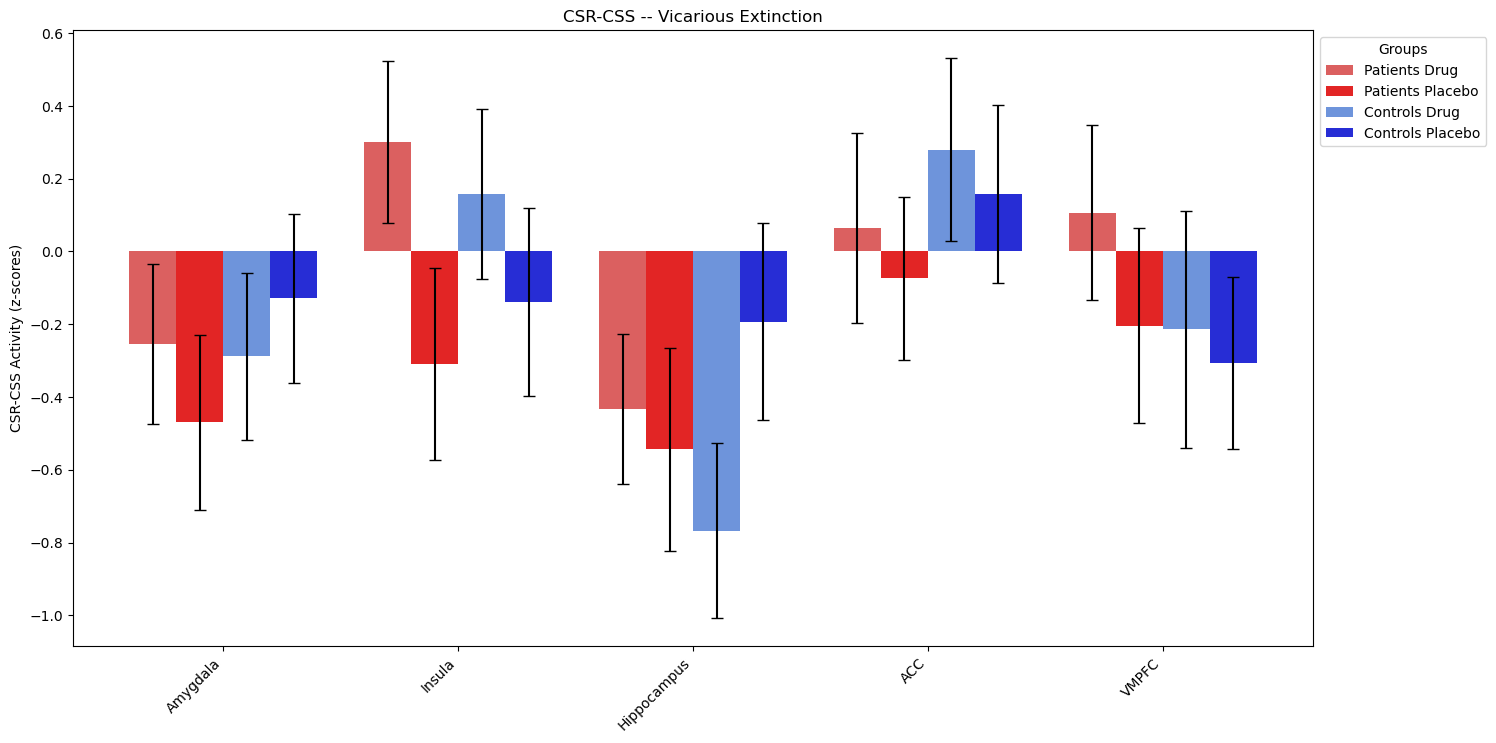

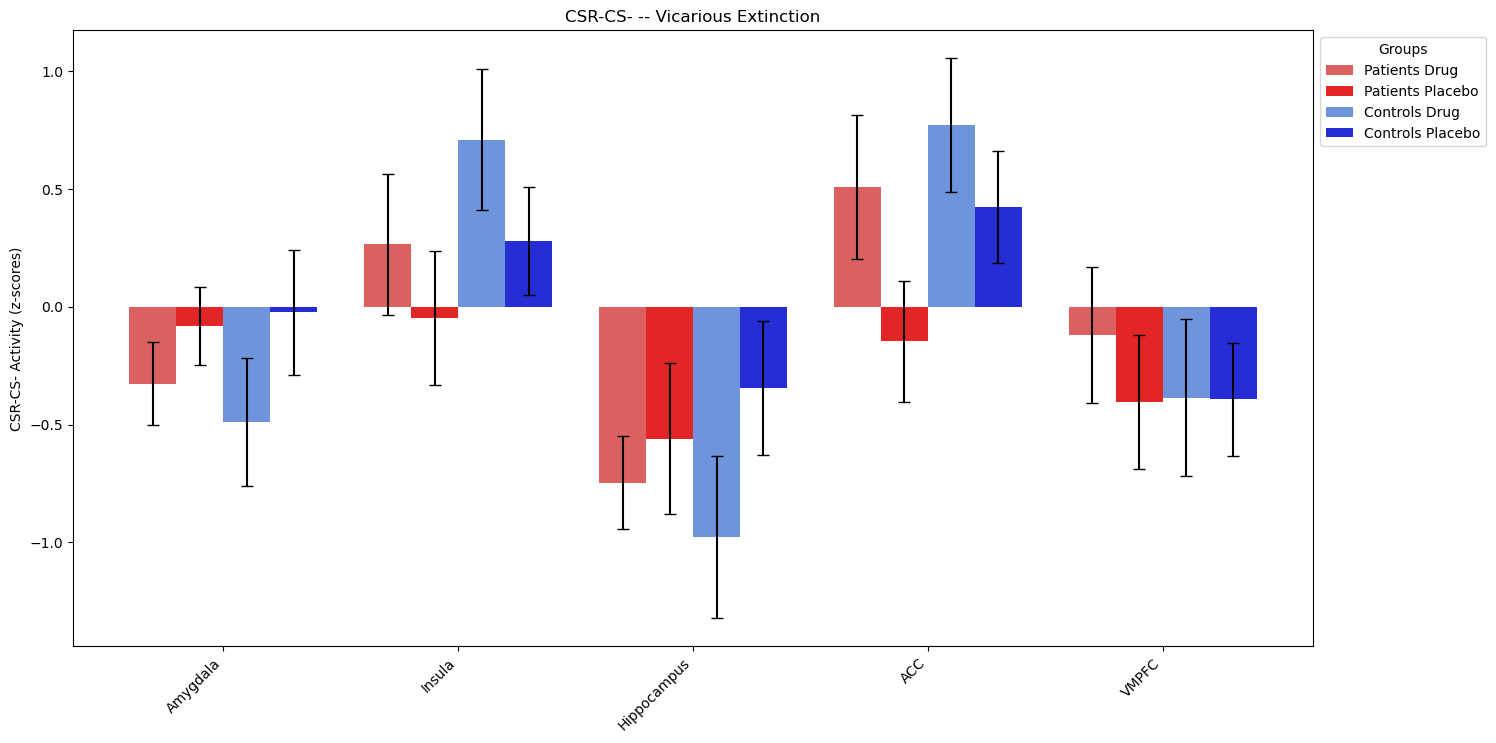

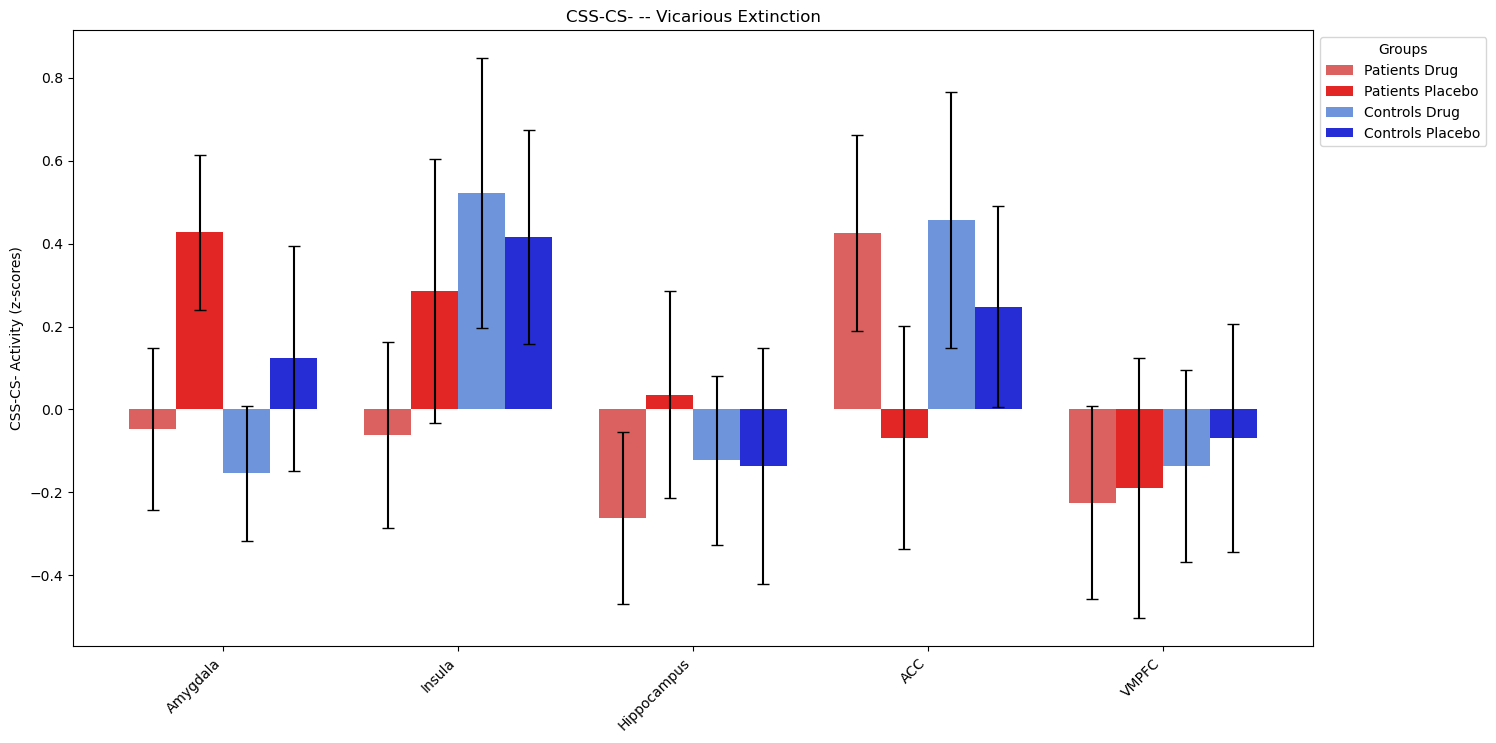

In [67]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')




In [79]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7644
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.578
Time:                        15:48:13   Log-Likelihood:                -148.24
No. Observations:                 100   AIC:                             308.5
Df Residuals:                      94   BIC:                             324.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

### reinstatement - second-level

In [83]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.6653
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.519
Time:                        15:57:32   Log-Likelihood:                -81.463
No. Observations:                  50   AIC:                             168.9
Df Residuals:                      47   BIC:                             174.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.58

In [84]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3794
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.862
Time:                        15:59:13   Log-Likelihood:                -165.67
No. Observations:                 101   AIC:                             343.3
Df Residuals:                      95   BIC:                             359.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

##### drug vs group post-hoc

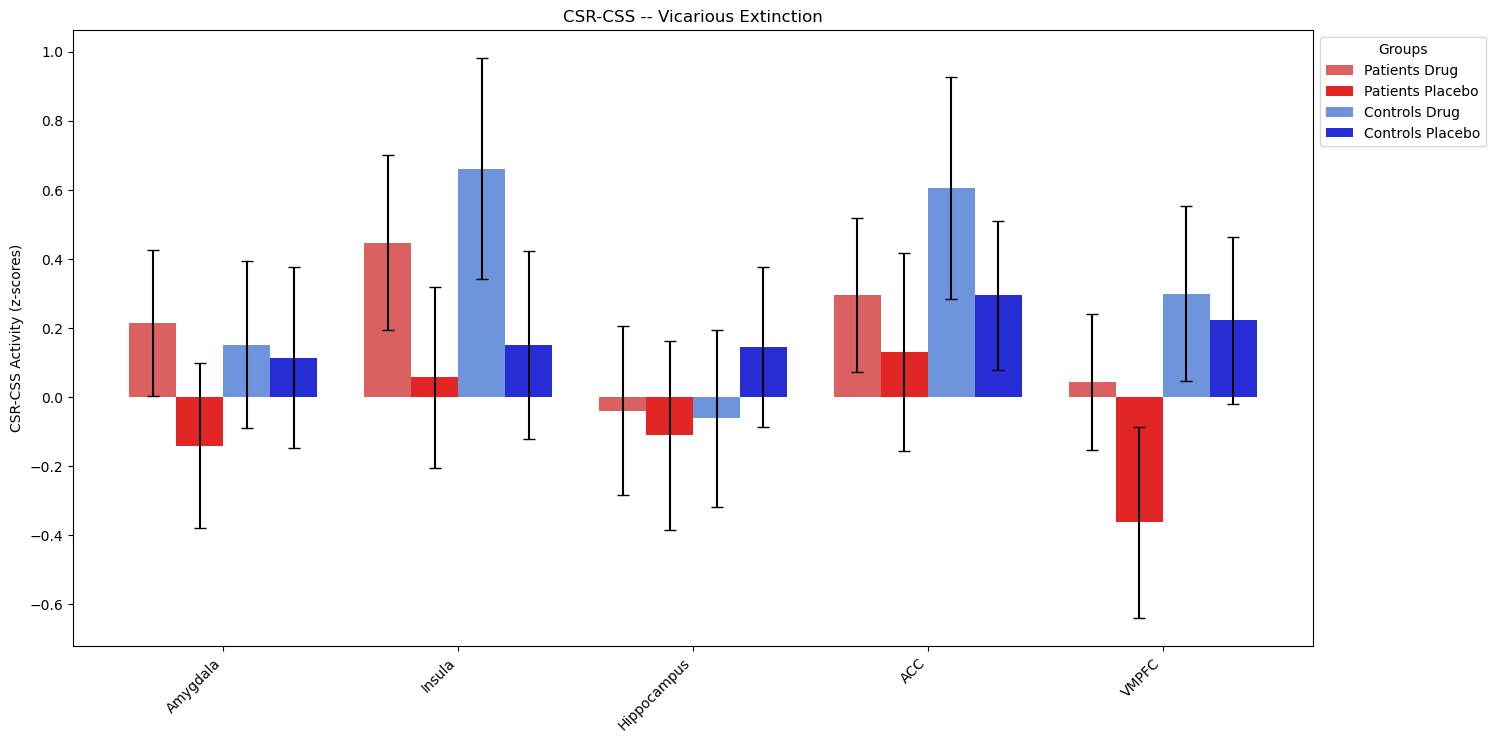

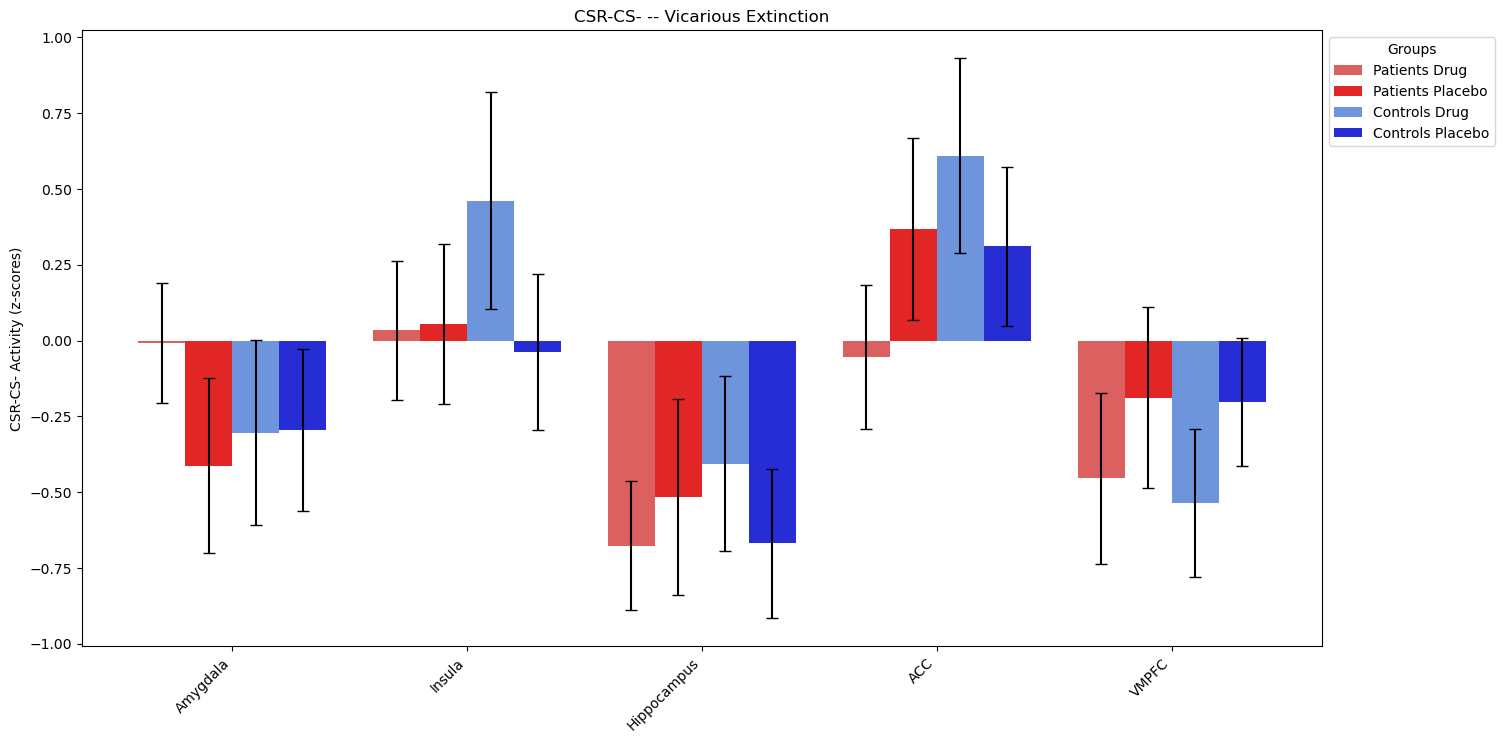

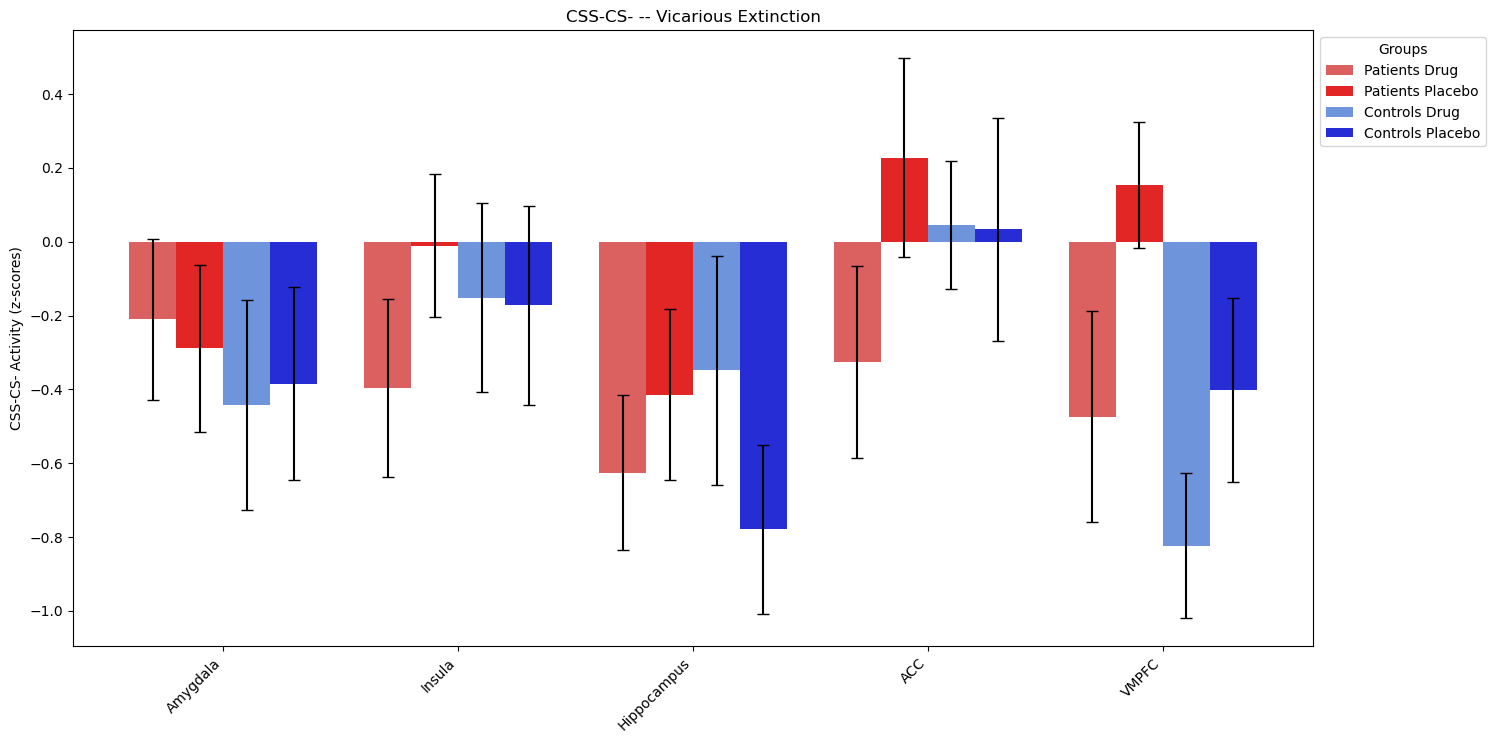

In [85]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')




In [89]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSS-CS-'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['patients_drug','patients_placebo','controls_drug','controls_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['patients_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['controls_drug'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Controls Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['controls_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Controls Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['patients_placebo'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Placebo vs Controls Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3[contrast]
    region_all_data = {
        'patients_drug': extract_group_data(patients_drug, region_data, region_no),
        'patients_placebo': extract_group_data(patients_placebo, region_data, region_no),
        'controls_drug': extract_group_data(controls_drug, region_data, region_no),
        'controls_placebo': extract_group_data(controls_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,patients_drug vs. 0,-0.946790,0.352463
1,Amygdala,patients_placebo vs. 0,-1.250071,0.225025
2,Amygdala,controls_drug vs. 0,-1.519050,0.142378
3,Amygdala,controls_placebo vs. 0,-1.445298,0.159882
4,Amygdala,Patients Drug vs Placebo,0.241073,0.810547
5,Amygdala,Controls Drug vs Placebo,-0.143815,0.886224
6,Amygdala,Patients Drug vs Controls Drug,0.637464,0.526790
7,Amygdala,Patients Placebo vs Controls Placebo,0.264005,0.792906
8,Insula,patients_drug vs. 0,-1.605241,0.120520
9,Insula,patients_placebo vs. 0,-0.053170,0.958099


##### drug vs gender post-hoc

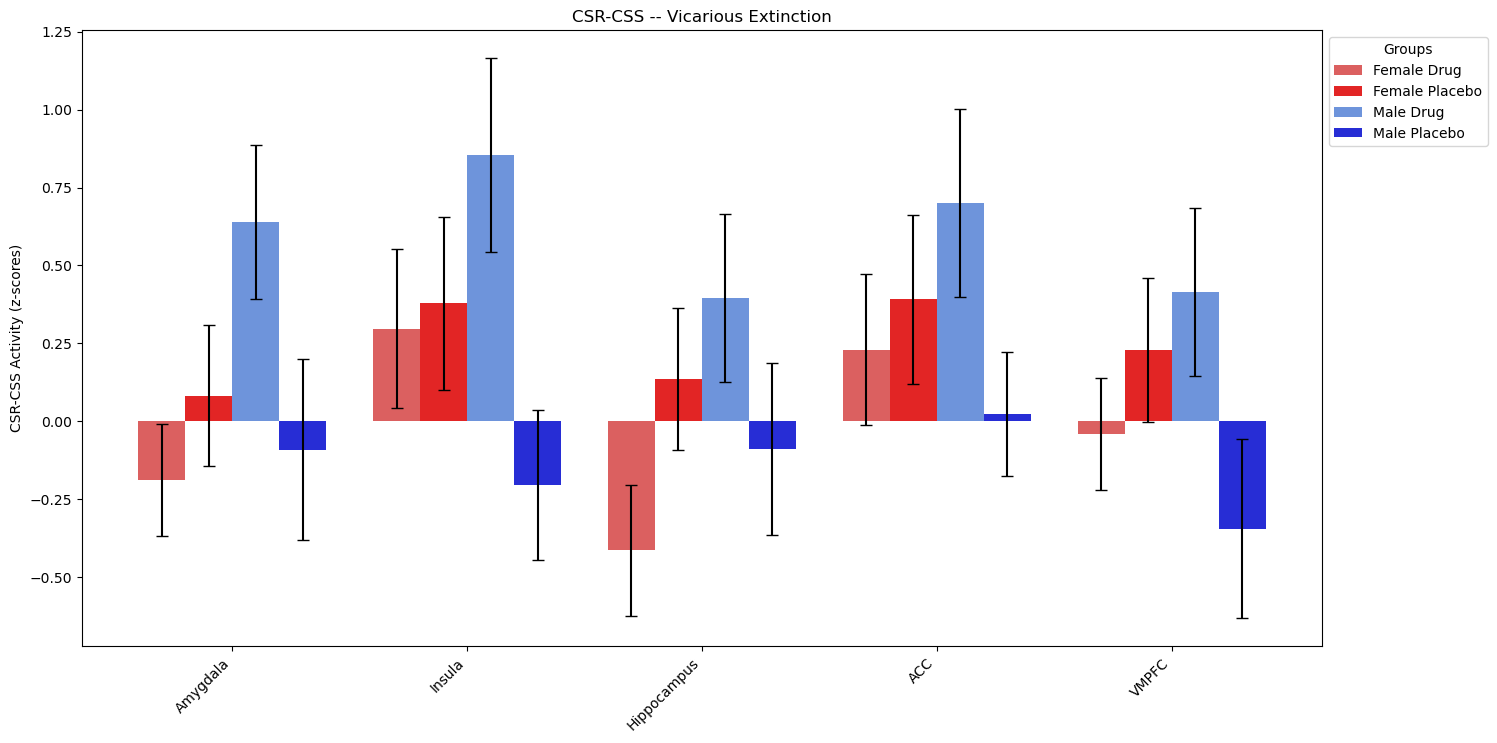

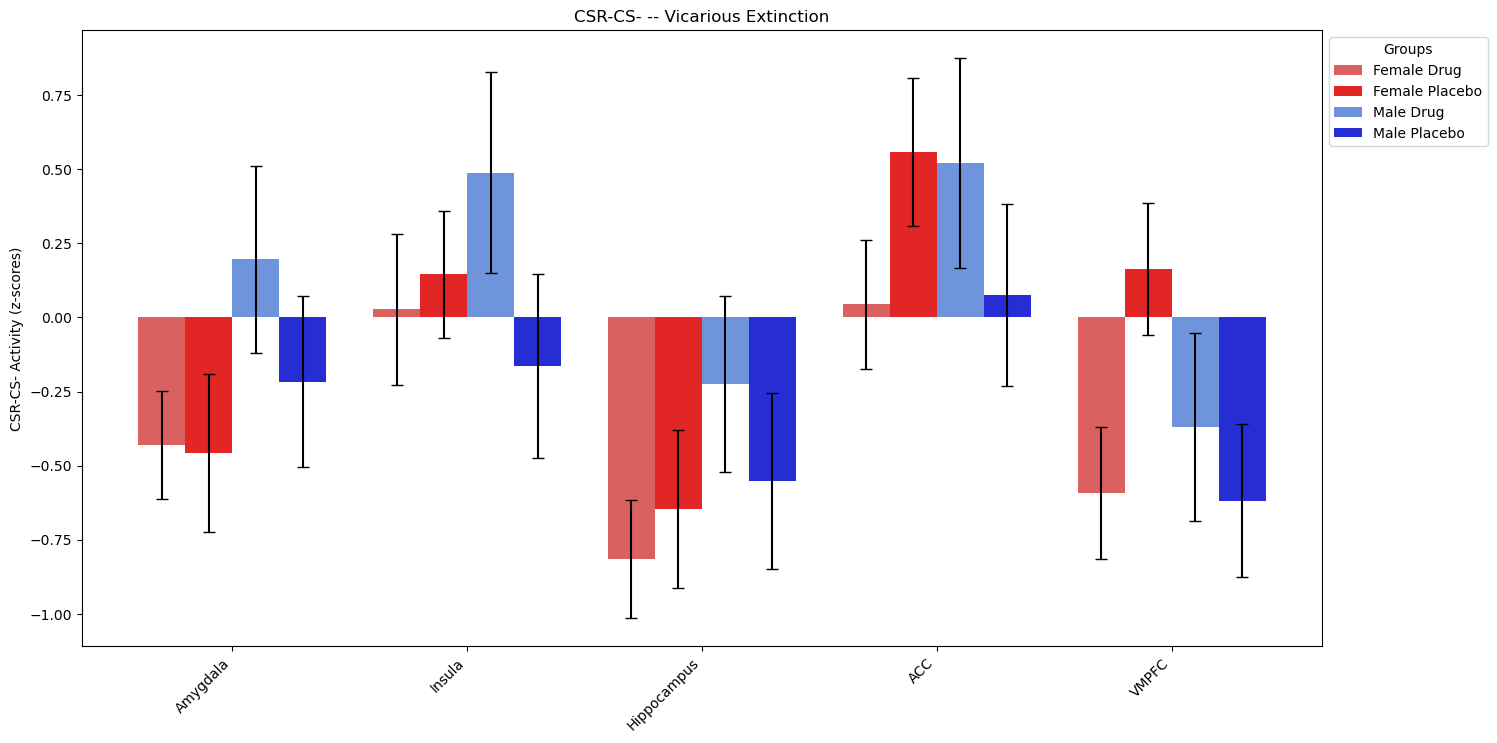

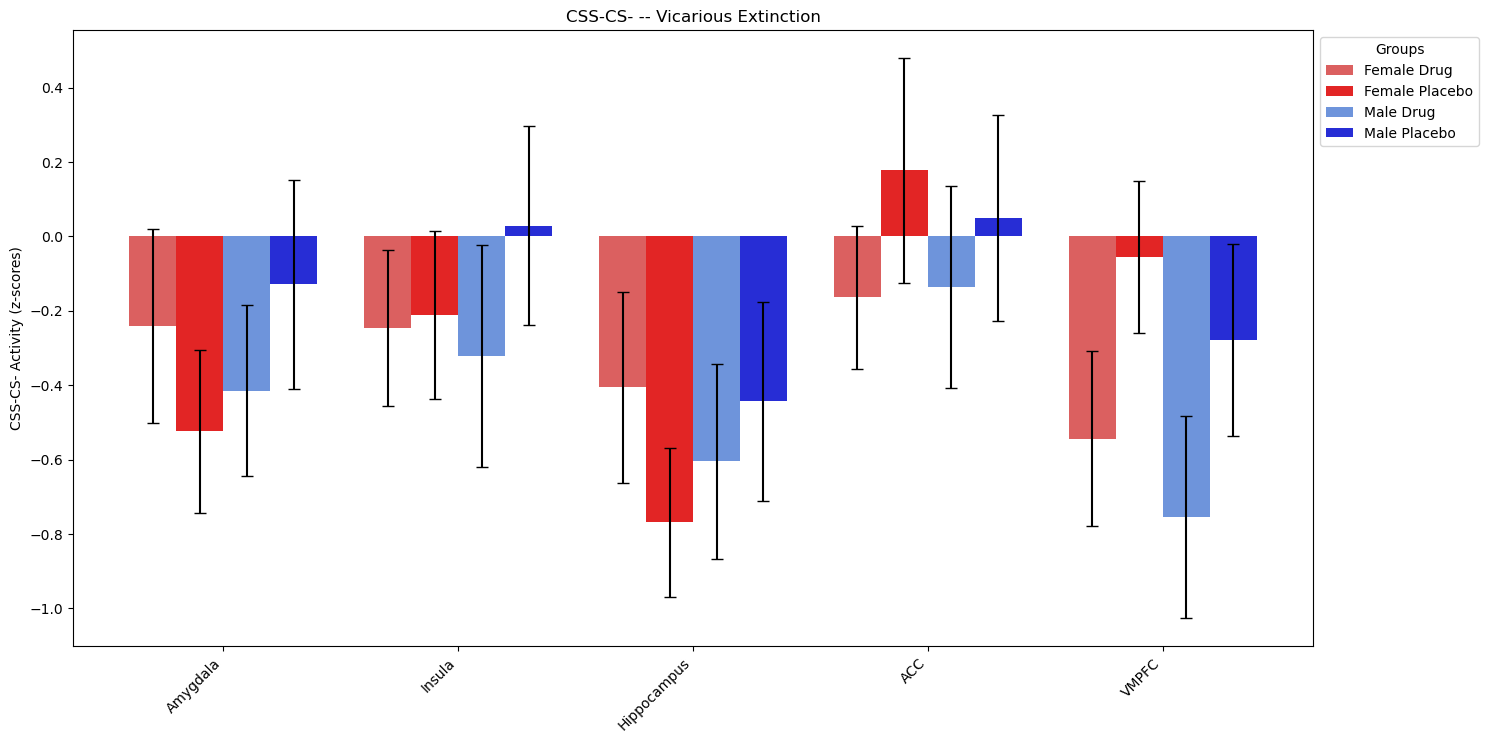

In [91]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['female_drug', 'female_placebo', 'male_drug', 'male_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'female_drug': group_stats(female_drug, data),
        'female_placebo': group_stats(female_placebo, data),
        'male_drug': group_stats(male_drug, data),
        'male_placebo': group_stats(male_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')




In [94]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSR-CSS'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['female_drug','female_placebo','male_drug','male_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['female_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['male_drug'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Males Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['male_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Females Drug vs Males Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['female_placebo'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Placebo vs Male Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Retrieve groups by calling the function
female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3['CSS-CS-']
    region_all_data = {
        'female_drug': extract_group_data(female_drug, region_data, region_no),
        'female_placebo': extract_group_data(female_placebo, region_data, region_no),
        'male_drug': extract_group_data(male_drug, region_data, region_no),
        'male_placebo': extract_group_data(male_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,female_drug vs. 0,-0.905235,0.373348
1,Amygdala,female_placebo vs. 0,-2.352820,0.026476
2,Amygdala,male_drug vs. 0,-1.758000,0.092654
3,Amygdala,male_placebo vs. 0,-0.450484,0.656770
4,Amygdala,Female Drug vs Placebo,0.813606,0.419511
5,Amygdala,Males Drug vs Placebo,-0.769897,0.445475
6,Amygdala,Females Drug vs Males Drug,0.478573,0.634371
7,Amygdala,Female Placebo vs Male Placebo,-1.104149,0.275033
8,Insula,female_drug vs. 0,-1.158910,0.256640
9,Insula,female_placebo vs. 0,-0.921998,0.365007


## Early vs late

### First Level

In [10]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [11]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [12]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

file_lists_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSRearly-CSSearly": (basic_contrasts["CSR-early"] - basic_contrasts["CSS-early"]),   
            "CSRearly-CS-early": (basic_contrasts["CSR-early"] - basic_contrasts["CS--early"]),   
            "CSSearly-CS-early": (basic_contrasts["CSS-early"] - basic_contrasts["CS--early"]), 
            "CSRearly-fixearly": (basic_contrasts["CSR-early"] - basic_contrasts["FIXATION-early"]),   
            "CSSearly-fixearly": (basic_contrasts["CSS-early"] - basic_contrasts["FIXATION-early"]),   
            "CSminusearly-fixearly": (basic_contrasts["CS--early"] - basic_contrasts["FIXATION-early"]),
            "CSRlate-CSSlate": (basic_contrasts["CSR-late"] - basic_contrasts["CSS-late"]),   
            "CSRlate-CS-late": (basic_contrasts["CSR-late"] - basic_contrasts["CS--late"]),   
            "CSSlate-CS-late": (basic_contrasts["CSS-late"] - basic_contrasts["CS--late"]), 
            "CSRlate-fixlate": (basic_contrasts["CSR-late"] - basic_contrasts["FIXATION-late"]),   
            "CSSlate-fixlate": (basic_contrasts["CSS-late"] - basic_contrasts["FIXATION-late"]),   
            "CSminuslate-fixlate": (basic_contrasts["CS--late"] - basic_contrasts["FIXATION-late"]), 
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
with pd.ExcelWriter('phase3_data.xlsx') as writer:
    for contrast in file_lists_phase3.keys():  # Loop through each contrast
        contrast_list = file_lists_phase3[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


Excel file with z-scores saved successfully!


### Extinction 

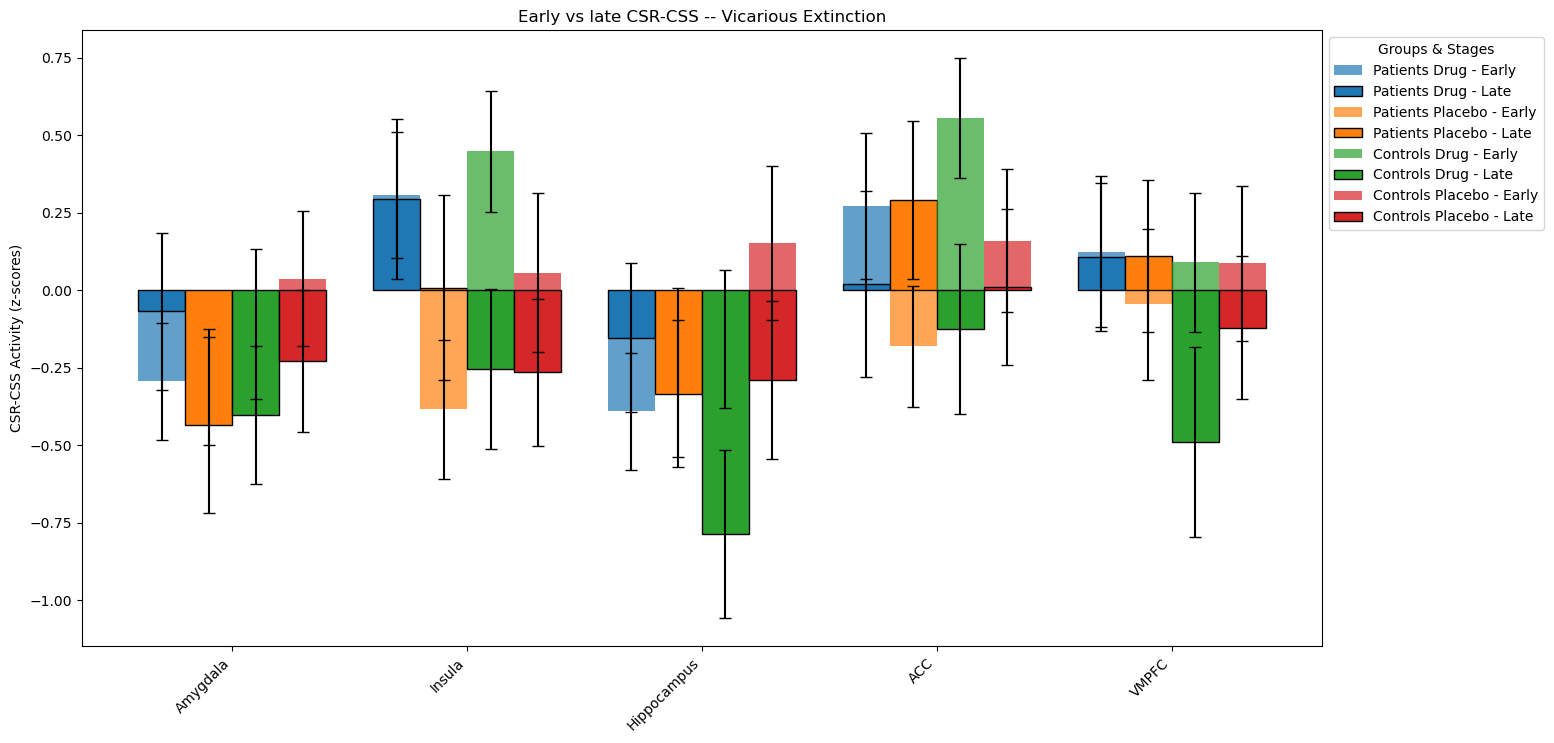

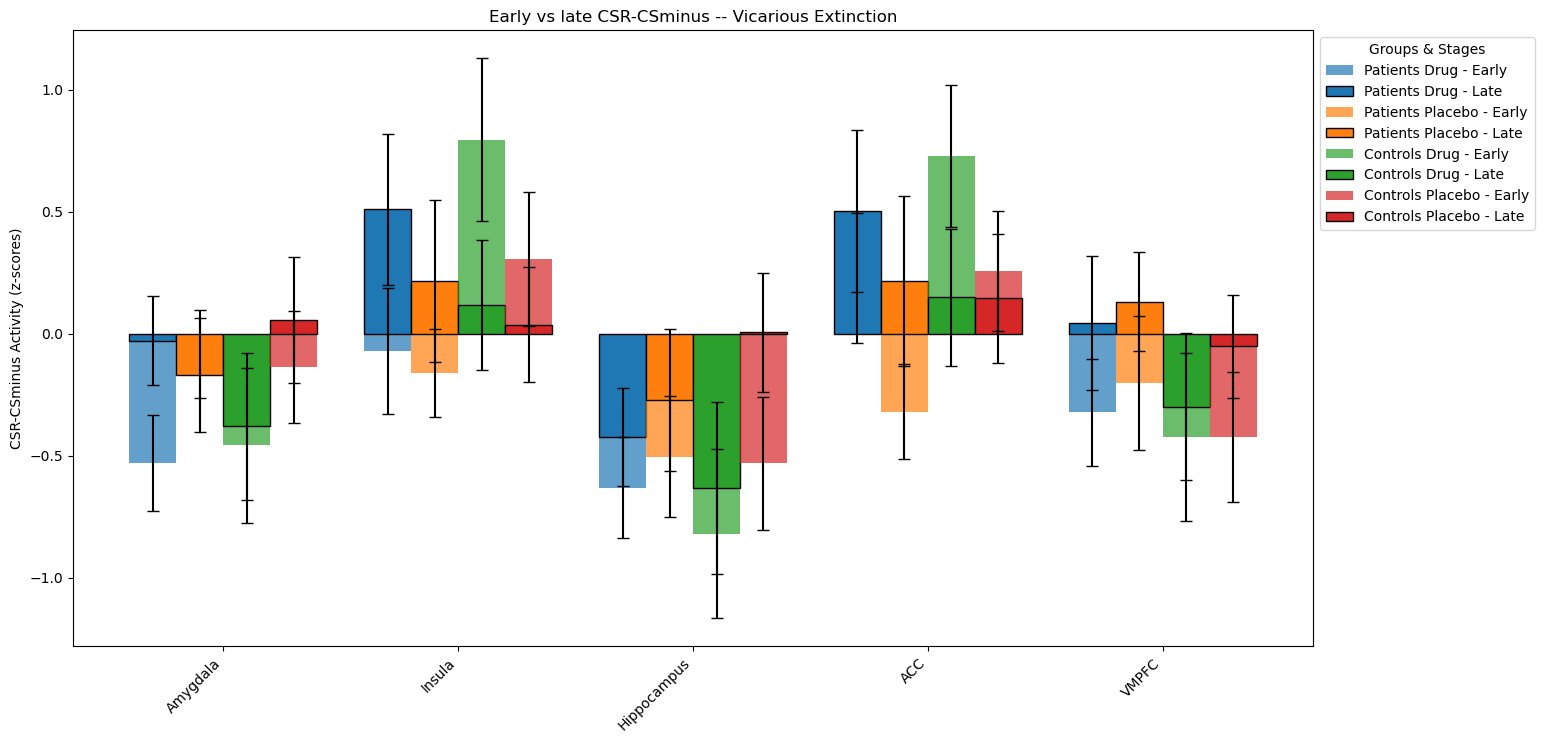

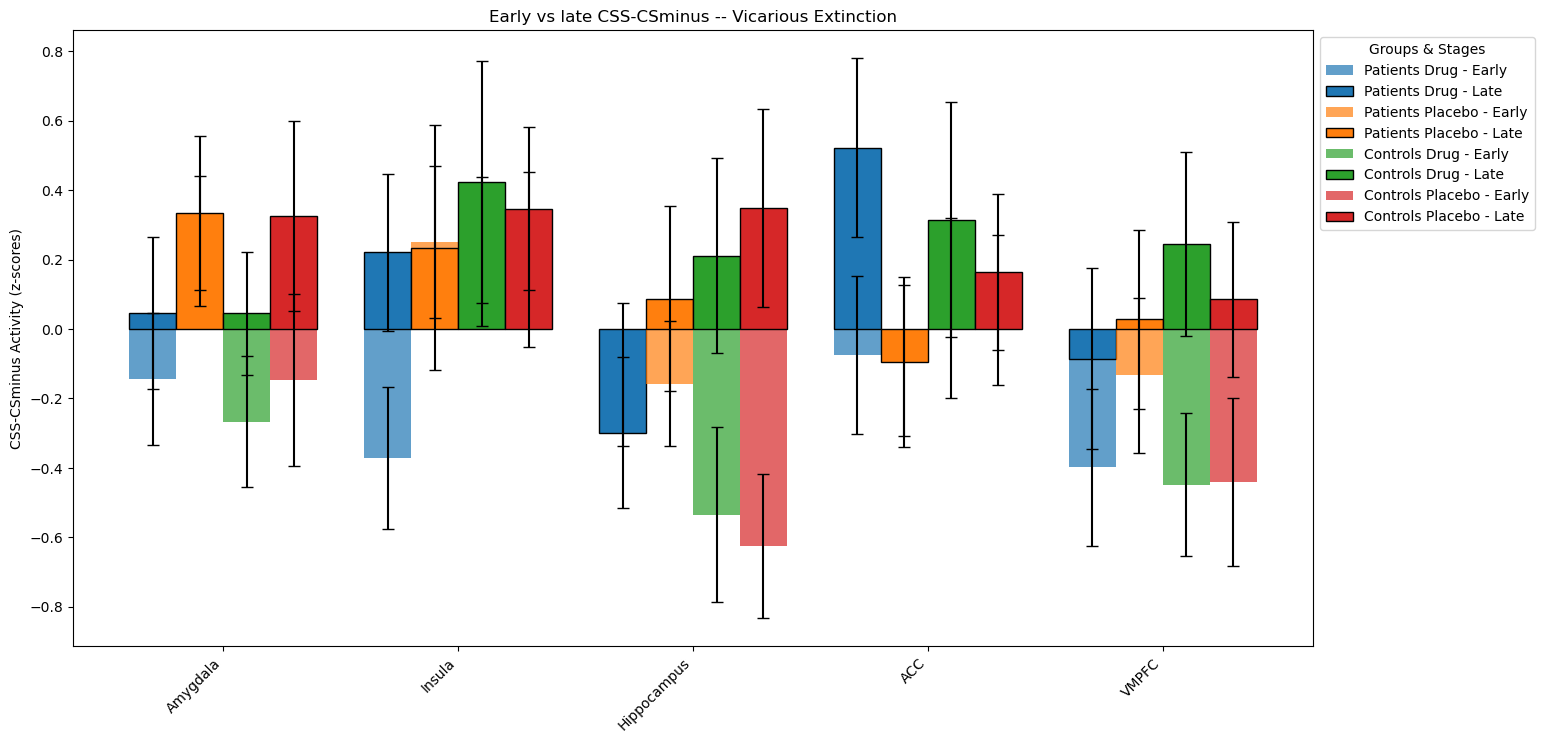

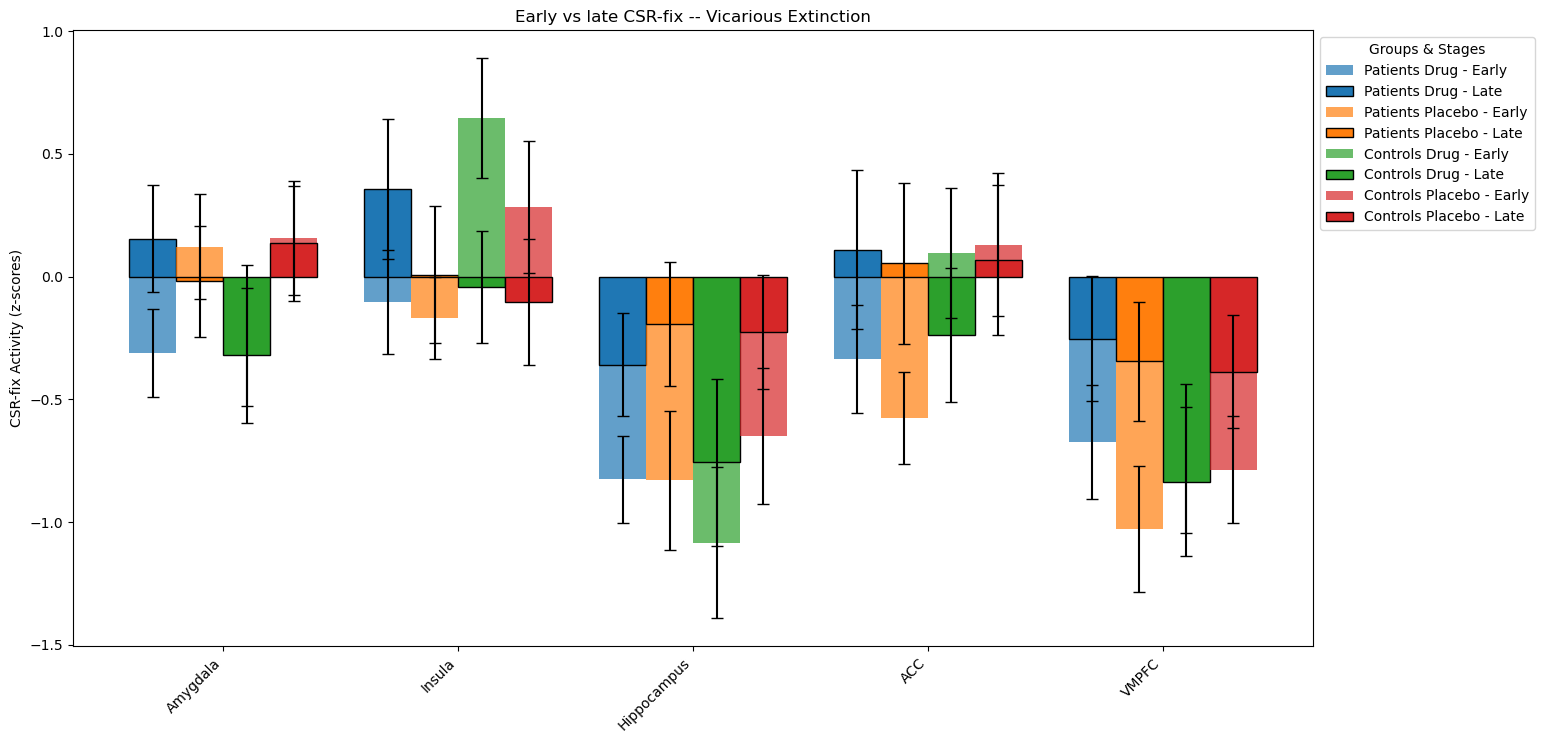

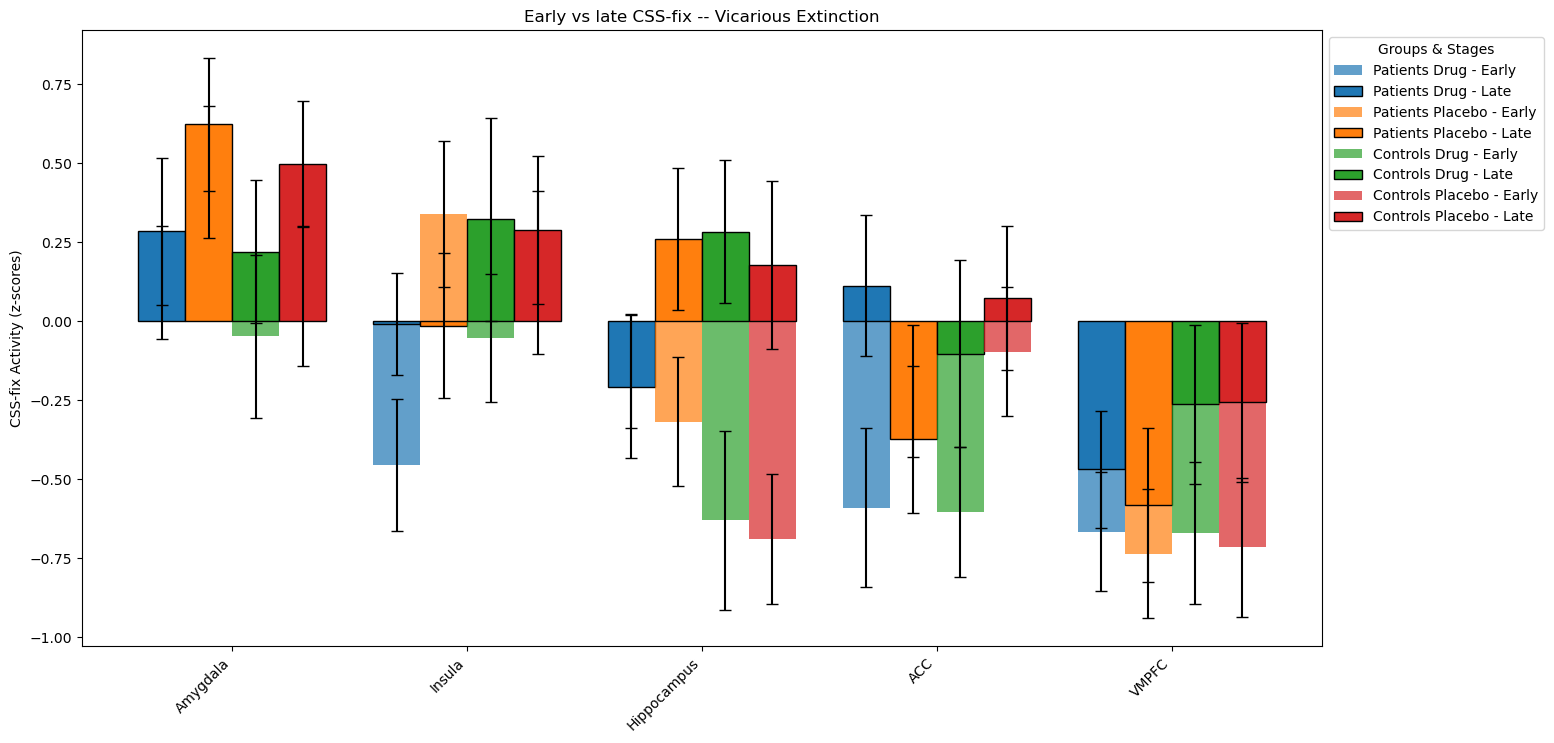

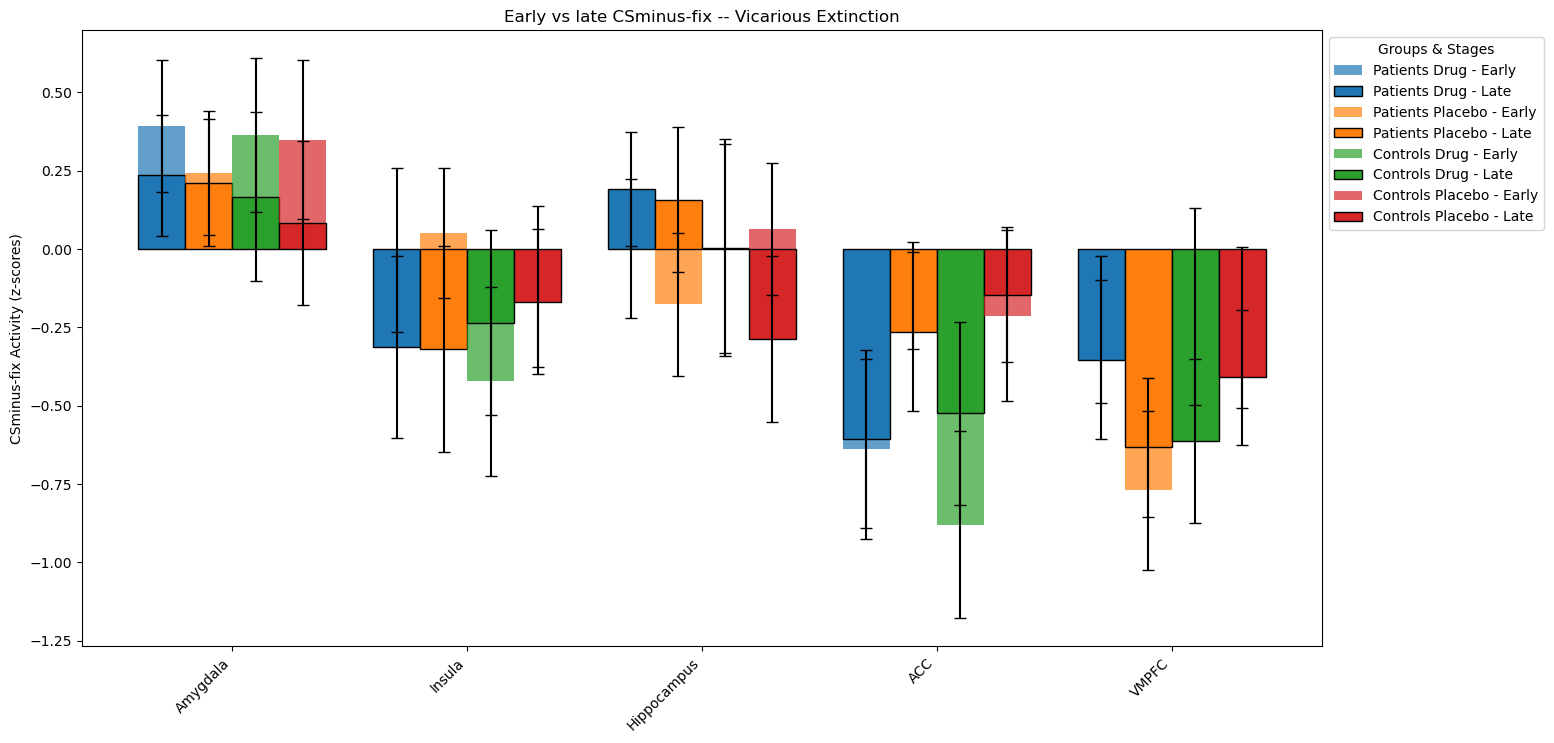

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_vicextinction.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_vicextinction.png')


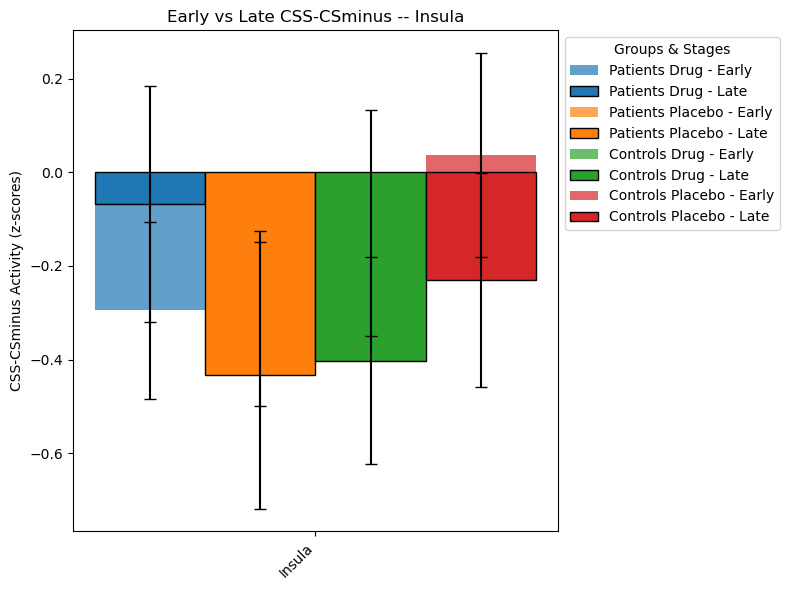

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define only Insula as the region of interest
regions_of_interest = ['Insula']

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for Insula only with error bars
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(8, 6))  # Adjusted size for single region plot
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each stage (Early and Late) as grouped bars with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for Insula
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Insula')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
region_no = regions_of_interest.index('Insula')
region = 'Insula'
contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'
region_data_early = file_lists_phase2[contrast_early]
region_data_late = file_lists_phase2[contrast_late]

stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
all_stats[region] = stats

# Plot the multibar plot for Insula only
plot_multibar_with_error_bars(all_stats, title, filename=f'{title}_Insula_vicextinction.png')


In [ ]:
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]
regions_of_interest.index('Insula')

1

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5678
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.803
Time:                        12:39:47   Log-Likelihood:                -310.82
No. Observations:                 200   AIC:                             639.6
Df Residuals:                     191   BIC:                             669.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase2[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Drug Early vs Late,-0.703573,0.484837
1,Amygdala,Patients Placebo Early vs Late,0.349061,0.728788
2,Amygdala,Controls Drug Early vs Late,0.880961,0.382919
3,Amygdala,Controls Placebo Early vs Late,0.826673,0.412200
4,Amygdala,Patients Drug vs Placebo (Early),0.065690,0.947903
5,Amygdala,Controls Drug vs Placebo (Early),-0.435920,0.664810
6,Amygdala,Patients Drug vs Controls Drug (Early),-0.602415,0.549676
7,Amygdala,Patients Placebo vs Controls Placebo (Early),-1.160904,0.251543
8,Amygdala,Patients Drug vs Placebo (Late),0.943394,0.350304
9,Amygdala,Controls Drug vs Placebo (Late),-0.529953,0.598538


#### placebo only! 

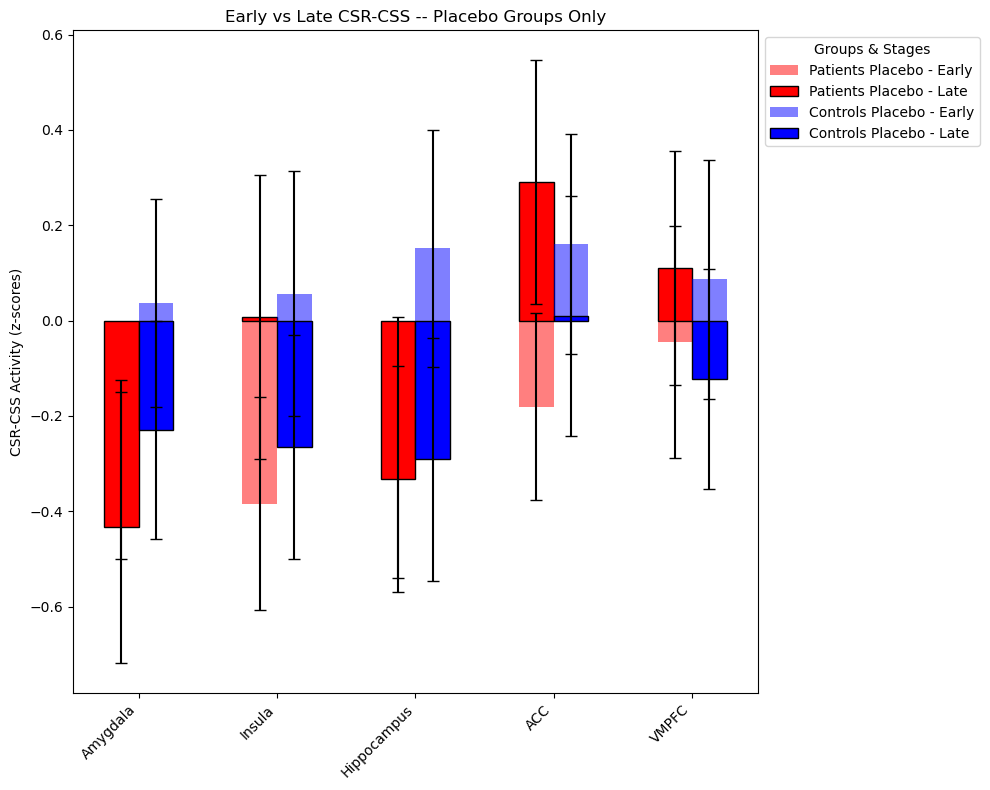

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_vicext_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7237
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.540
Time:                        16:21:56   Log-Likelihood:                -152.49
No. Observations:                  98   AIC:                             313.0
Df Residuals:                      94   BIC:                             323.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase2[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Placebo Early vs Late,0.349061,0.728788
1,Amygdala,Controls Placebo Early vs Late,0.826673,0.412200
2,Amygdala,Patients Placebo vs Controls Placebo (Early),-1.160904,0.251543
3,Amygdala,Patients Placebo vs Controls Placebo (Late),-0.554807,0.581658
4,Insula,Patients Placebo Early vs Late,-1.029697,0.309046
5,Insula,Controls Placebo Early vs Late,0.906388,0.368912
6,Insula,Patients Placebo vs Controls Placebo (Early),-1.238171,0.221802
7,Insula,Patients Placebo vs Controls Placebo (Late),0.714789,0.478275
8,Hippocampus,Patients Placebo Early vs Late,0.181913,0.856526
9,Hippocampus,Controls Placebo Early vs Late,1.221607,0.227366


### Reinstatement

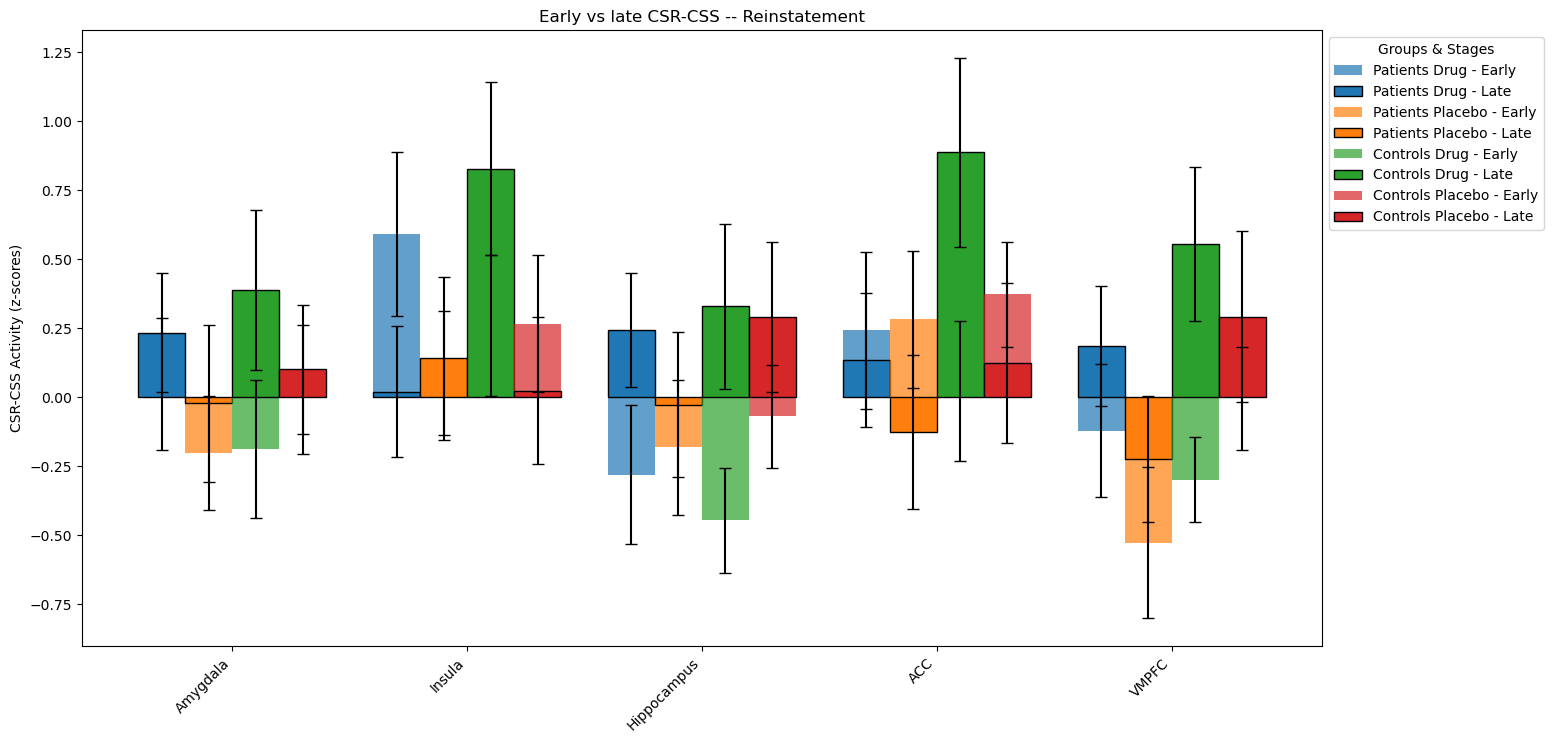

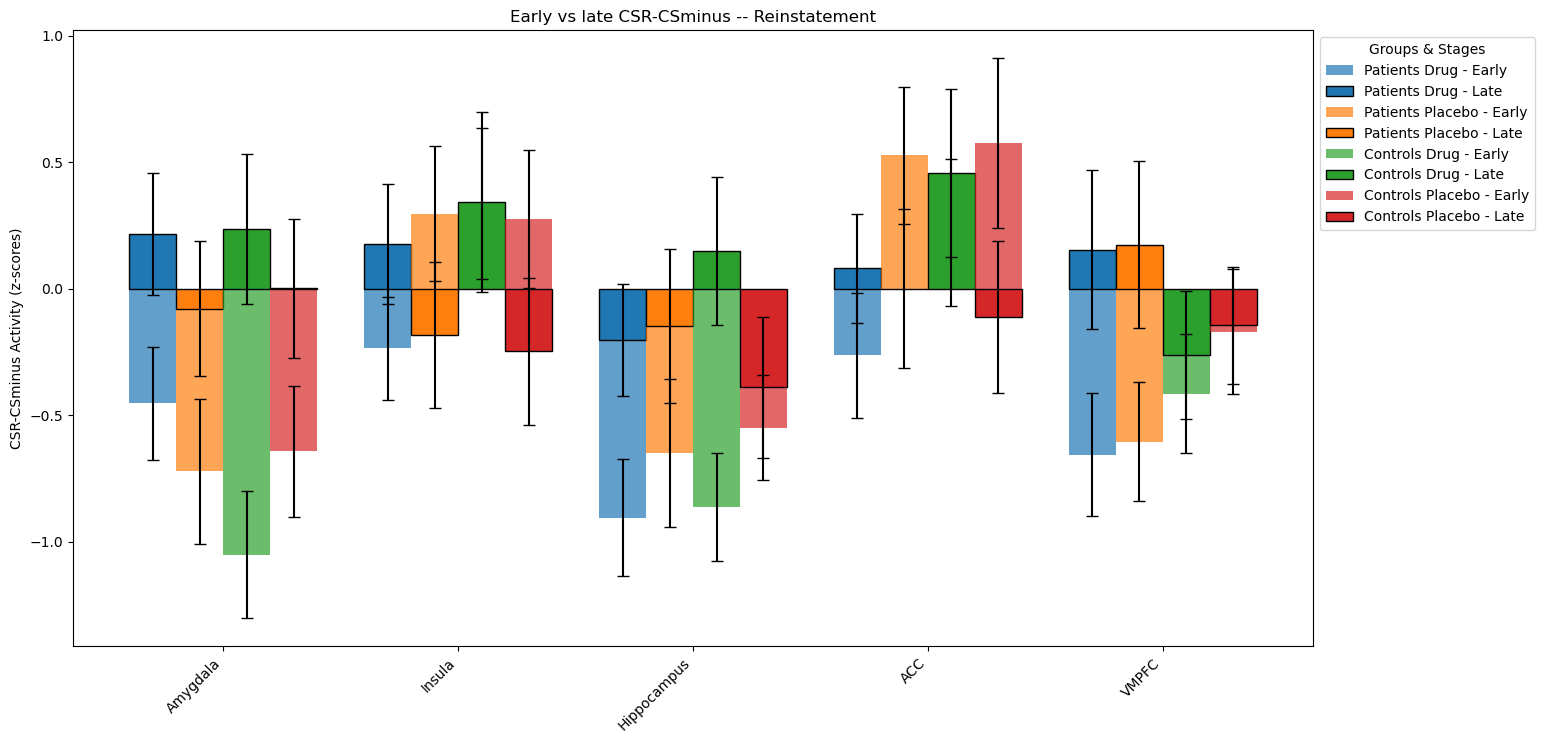

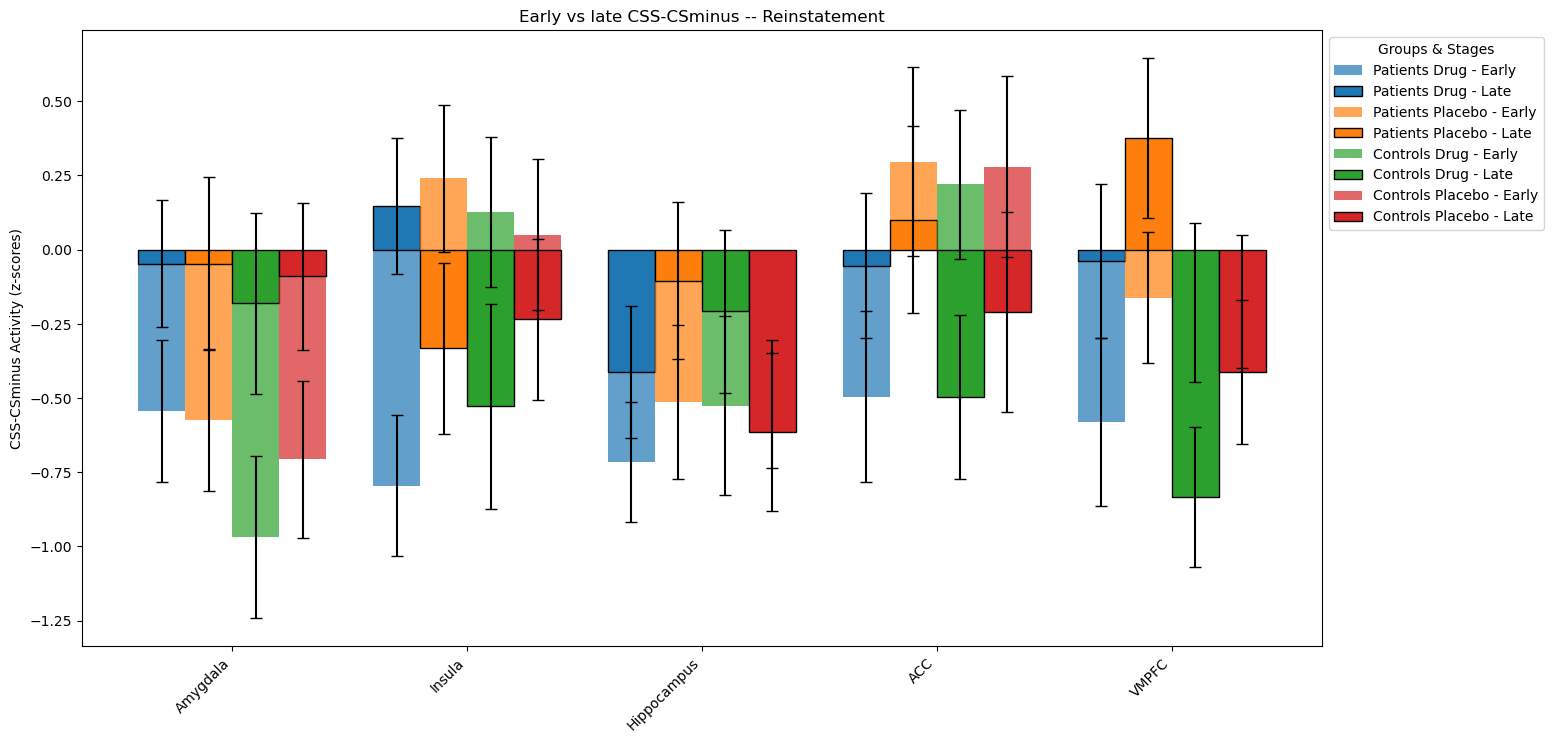

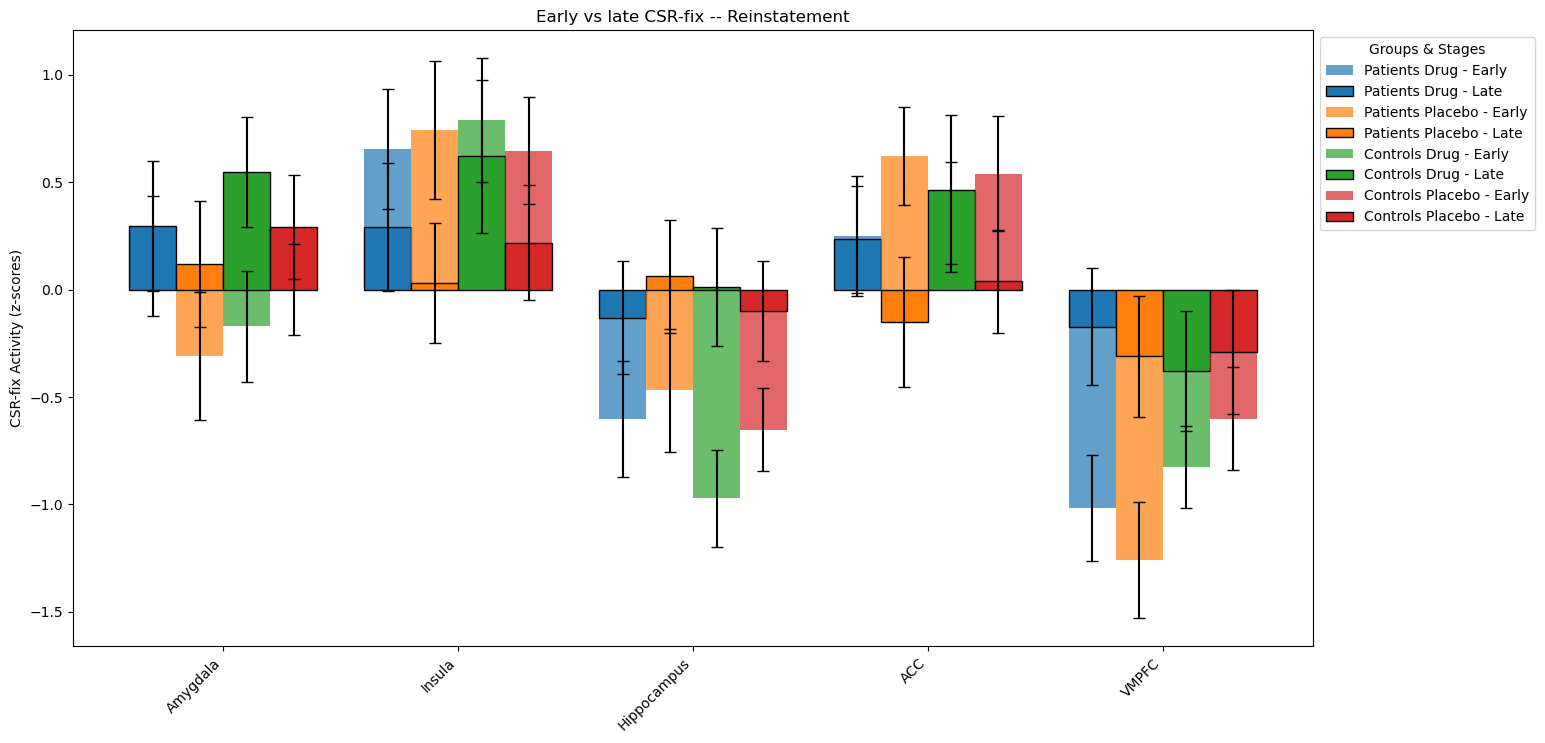

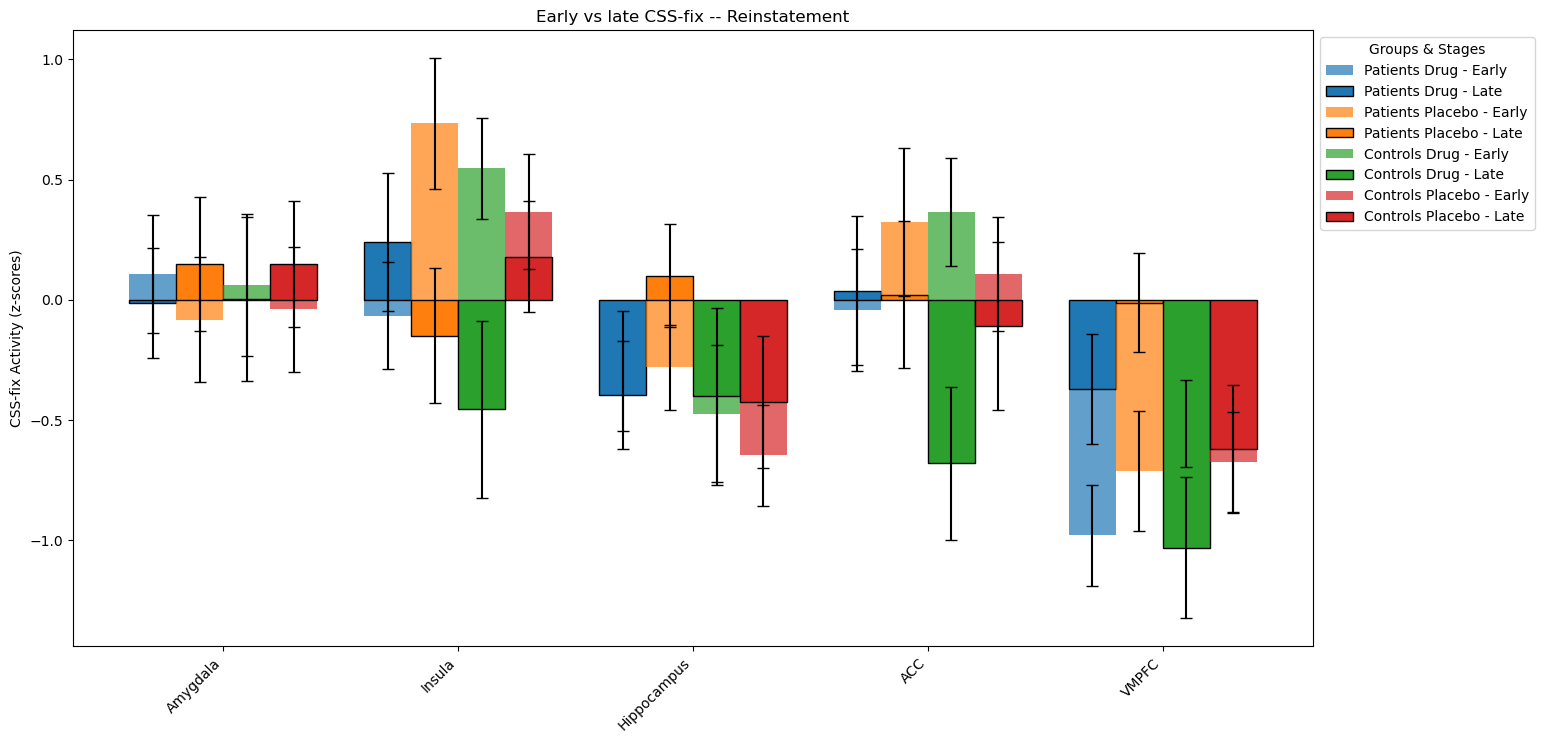

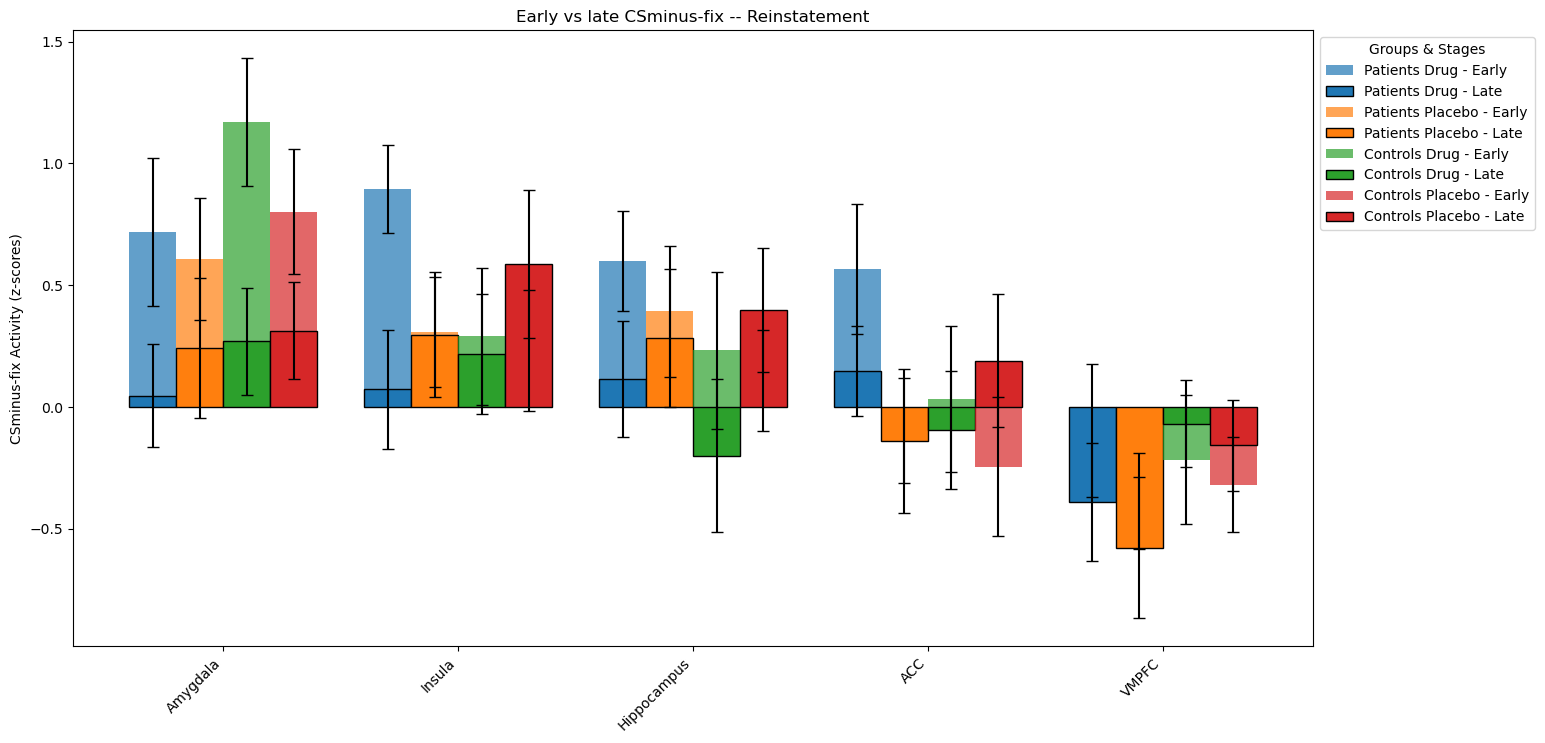

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_reinstatement.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_reinstatement.png')


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.7305
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.664
Time:                        16:33:11   Log-Likelihood:                -327.61
No. Observations:                 202   AIC:                             673.2
Df Residuals:                     193   BIC:                             703.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Drug Early vs Late,-0.569364,0.571561
1,Amygdala,Patients Placebo Early vs Late,-0.502464,0.617966
2,Amygdala,Controls Drug Early vs Late,-1.473562,0.147410
3,Amygdala,Controls Placebo Early vs Late,-0.217551,0.828599
4,Amygdala,Patients Drug vs Placebo (Early),0.754667,0.454214
5,Amygdala,Controls Drug vs Placebo (Early),-0.617165,0.539926
6,Amygdala,Patients Drug vs Controls Drug (Early),0.665939,0.508573
7,Amygdala,Patients Placebo vs Controls Placebo (Early),-0.701626,0.486301
8,Amygdala,Patients Drug vs Placebo (Late),0.711254,0.480442
9,Amygdala,Controls Drug vs Placebo (Late),0.762196,0.449524


#### Just placebo ! 

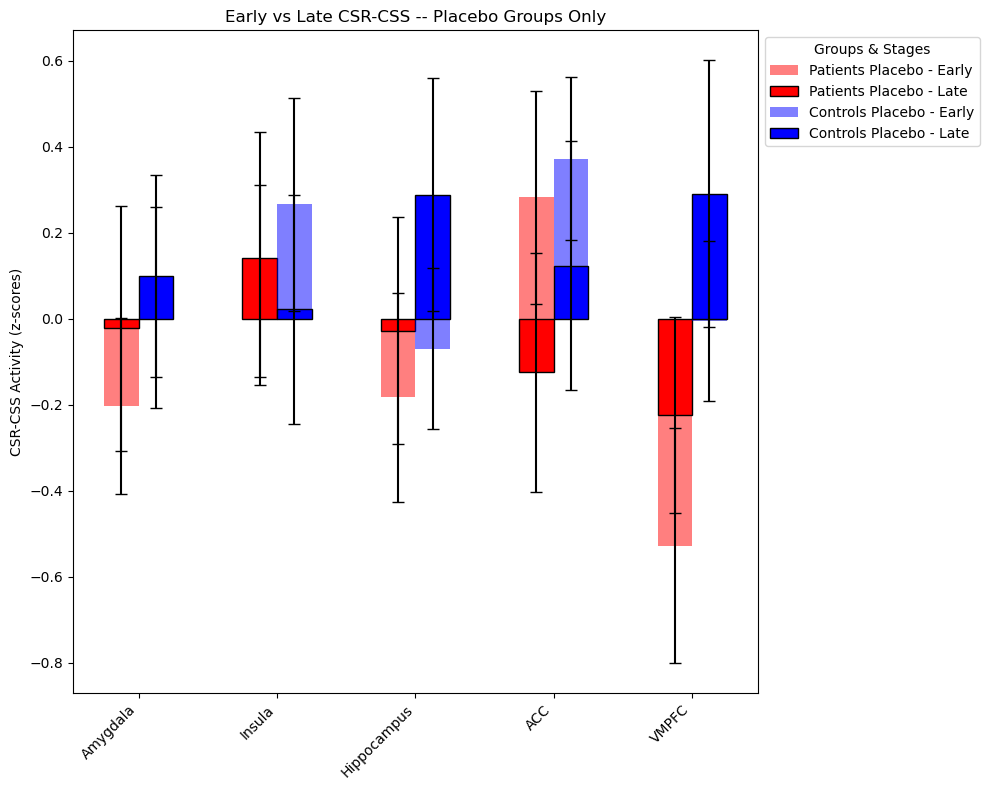

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_reinstatement_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2628
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.852
Time:                        16:39:13   Log-Likelihood:                -160.74
No. Observations:                 100   AIC:                             329.5
Df Residuals:                      96   BIC:                             339.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase3[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Placebo Early vs Late,-0.502464,0.617966
1,Amygdala,Controls Placebo Early vs Late,-0.217551,0.828599
2,Amygdala,Patients Placebo vs Controls Placebo (Early),-0.701626,0.486301
3,Amygdala,Patients Placebo vs Controls Placebo (Late),-0.327621,0.744623
4,Insula,Patients Placebo Early vs Late,-0.140064,0.889279
5,Insula,Controls Placebo Early vs Late,0.656702,0.514162
6,Insula,Patients Placebo vs Controls Placebo (Early),-0.510501,0.612040
7,Insula,Patients Placebo vs Controls Placebo (Late),0.289853,0.773177
8,Hippocampus,Patients Placebo Early vs Late,-0.422941,0.674496
9,Hippocampus,Controls Placebo Early vs Late,-1.068728,0.289947
